<a href="https://colab.research.google.com/github/jaimeisaac2020/ARIMA/blob/master/aplicacion_tesis_jaime_marioipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime

def collect_financial_data(start_date, end_date):
    """
    Descarga y consolida datos financieros para Google, Amazon y variables macroeconómicas.
    Esta versión está actualizada para funcionar con las últimas versiones de yfinance.

    Args:
        start_date (str): Fecha de inicio en formato 'YYYY-MM-DD'.
        end_date (str): Fecha de fin en formato 'YYYY-MM-DD'.

    Returns:
        pandas.DataFrame: Un DataFrame consolidado con todas las variables y fechas como índice.
    """
    print(f"Iniciando la descarga de datos desde {start_date} hasta {end_date}...")

    # --- Paso 1: Definir los tickers y símbolos ---
    yf_tickers = ['GOOGL', 'AMZN', '^GSPC', '^IXIC', '^VIX']
    fred_symbols = {
        'DGS10': 'Treasury_10Y',
        'T5YIE': 'Inflacion_T5YIE'
    }

    # --- Paso 2: Descargar datos de Yahoo Finance ---
    try:
        print("Descargando datos de acciones e índices desde Yahoo Finance...")
        # yfinance ahora usa auto_adjust=True por defecto, por lo que 'Close' ya es el precio ajustado.
        yf_data = yf.download(yf_tickers, start=start_date, end=end_date, progress=False)

        # Seleccionamos la columna 'Close' que ahora contiene los precios ajustados
        close_data = yf_data['Close']

        # Renombramos las columnas para que sean más limpias
        close_data = close_data.rename(columns={
            'GOOGL': 'GOOGL_Close',
            'AMZN': 'AMZN_Close',
            '^GSPC': 'SP500',
            '^IXIC': 'NASDAQ',
            '^VIX': 'VIX'
        })
        print("-> Datos de Yahoo Finance descargados exitosamente.")
    except Exception as e:
        print(f"Error al descargar datos de Yahoo Finance: {e}")
        return None

    # --- Paso 3: Descargar datos macroeconómicos de FRED ---
    try:
        print("Descargando datos macroeconómicos desde FRED...")
        start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')

        fred_data = web.DataReader(list(fred_symbols.keys()), 'fred', start_dt, end_dt)
        fred_data = fred_data.rename(columns=fred_symbols)
        print("-> Datos de FRED descargados exitosamente.")
    except Exception as e:
        print(f"Error al descargar datos de FRED: {e}")
        return None

    # --- Paso 4: Unir los DataFrames ---
    print("Consolidando todos los datos en un único DataFrame...")
    consolidated_df = pd.concat([close_data, fred_data], axis=1)

    # --- Paso 5: Limpiar y Preprocesar el DataFrame Consolidado ---
    print("Limpiando y rellenando datos faltantes...")
    consolidated_df.fillna(method='ffill', inplace=True)
    consolidated_df.dropna(inplace=True)

    consolidated_df = consolidated_df.round(4)

    print("\nProceso de recolección de datos completado.")
    return consolidated_df

# --- Ejemplo de uso del Framework ---
if __name__ == '__main__':
    fecha_inicio = '2021-01-01'
    fecha_fin = '2024-12-31'

    final_dataset = collect_financial_data(start_date=fecha_inicio, end_date=fecha_fin)

    if final_dataset is not None:
        print("\n--- Vista Previa del Dataset Consolidado ---")
        print("Primeras 5 filas:")
        print(final_dataset.head())
        print("\nÚltimas 5 filas:")
        print(final_dataset.tail())
        print(f"\nDimensiones del dataset: {final_dataset.shape[0]} filas, {final_dataset.shape[1]} columnas")

        output_filename = 'dataset_completo_recolectado.csv'
        final_dataset.to_csv(output_filename)
        print(f"\nDataset guardado exitosamente como '{output_filename}'")

Iniciando la descarga de datos desde 2021-01-01 hasta 2024-12-31...
Descargando datos de acciones e índices desde Yahoo Finance...
-> Datos de Yahoo Finance descargados exitosamente.
Descargando datos macroeconómicos desde FRED...
-> Datos de FRED descargados exitosamente.
Consolidando todos los datos en un único DataFrame...
Limpiando y rellenando datos faltantes...

Proceso de recolección de datos completado.

--- Vista Previa del Dataset Consolidado ---
Primeras 5 filas:
            AMZN_Close  GOOGL_Close      SP500      NASDAQ    VIX  \
2021-01-04    159.3315      85.7920  3700.6499  12698.4502  26.97   
2021-01-05    160.9255      86.4838  3726.8601  12818.9600  25.34   
2021-01-06    156.9190      85.6304  3748.1399  12740.7900  25.07   
2021-01-07    158.1080      88.1881  3803.7900  13067.4805  22.37   
2021-01-08    159.1350      89.3556  3824.6799  13201.9805  21.56   

            Treasury_10Y  Inflacion_T5YIE  
2021-01-04          0.93             1.98  
2021-01-05        

## MODULO 2 DE APLICACION

In [90]:
import pandas as pd
import numpy as np

def create_features_and_split(df, target_price_cols, test_size=0.2, lags=5):
    """
    Realiza la ingeniería de características y divide el dataset en conjuntos
    de entrenamiento y prueba para modelado supervisado.

    Args:
        df (pandas.DataFrame): El DataFrame consolidado del Módulo 1.
        target_price_cols (list): Lista de columnas de precios que se usarán para generar los retornos objetivo
                                 (ej. ['GOOGL_Close', 'AMZN_Close']).
        test_size (float): La proporción del dataset que se usará para el conjunto de prueba (ej. 0.2 para 20%).
        lags (int): El número de días de rezago a crear para las características.

    Returns:
        tuple: Una tupla conteniendo los DataFrames (X_train, X_test, y_train, y_test).
    """
    print("\n--- Iniciando Módulo 2: Ingeniería de Características ---")

    # --- Paso 1: Crear Variables Derivadas (Retornos y Volatilidad) ---
    print(f"Calculando retornos y volatilidades (ventana de 20 días)...")

    # Se crea una copia para evitar modificar el DataFrame original fuera de la función
    df_processed = df.copy()

    for col in target_price_cols:
        # Retorno porcentual diario
        df_processed[f'{col}_Return_1d'] = df_processed[col].pct_change()
        # Volatilidad de 20 días sobre los retornos
        df_processed[f'{col}_Volatility_20'] = df_processed[f'{col}_Return_1d'].rolling(window=20).std()

    # --- Paso 2: Crear las Variables Objetivo (Target) ---
    # El objetivo es predecir el retorno del DÍA SIGUIENTE.
    # Usamos shift(-1) para traer el retorno de mañana a la fila de hoy.
    print("Creando variables objetivo (retorno del día siguiente)...")
    target_names = []
    for col in target_price_cols:
        target_name = f'{col}_Target_Return'
        df_processed[target_name] = df_processed[f'{col}_Return_1d'].shift(-1)
        target_names.append(target_name)

    # --- Paso 3: Crear Características de Rezago (Lags) ---
    # Estas son las variables más importantes para capturar la memoria de la serie.
    print(f"Creando {lags} días de rezagos para todas las características predictoras...")

    # Lista de todas las columnas que no son targets para crearles lags
    features_to_lag = df_processed.columns.drop(target_names)

    df_lagged = df_processed.copy()
    for lag in range(1, lags + 1):
        shifted = df_processed[features_to_lag].shift(lag)
        shifted.columns = [f'{col}_lag_{lag}' for col in features_to_lag]
        df_lagged = pd.concat([df_lagged, shifted], axis=1)

    # --- Paso 4: Limpieza Final y Separación de X e y ---
    # Eliminar las filas con NaNs generados por los cálculos de rolling y shift.
    # Esto asegura que cada fila tenga un conjunto completo de características y un objetivo.
    df_lagged.dropna(inplace=True)

    # Definir 'y' (los targets) y 'X' (los predictores)
    y = df_lagged[target_names]

    # X son todas las columnas excepto los targets.
    X = df_lagged.drop(columns=target_names)

    print("-> Limpieza y separación de X (predictores) e y (objetivo) completadas.")

    # --- Paso 5: División Temporal (Train/Test Split) ---
    # Es crucial NO mezclar los datos. El entrenamiento se hace con datos más antiguos
    # y la prueba con los más recientes para simular un entorno de predicción realista.
    split_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    print(f"\nDivisión temporal realizada:")
    print(f" -> {1-test_size:.0%} para entrenamiento, {test_size:.0%} para prueba.")
    print(f" -> Tamaño de X_train: {X_train.shape}")
    print(f" -> Tamaño de X_test:  {X_test.shape}")
    print(f" -> Tamaño de y_train: {y_train.shape}")
    print(f" -> Tamaño de y_test:  {y_test.shape}")

    return X_train, X_test, y_train, y_test

# --- Bloque de Ejecución Principal (Ejemplo de Uso) ---
if __name__ == '__main__':

    # Nombre del archivo de entrada generado por el Módulo 1
    input_filename = 'dataset_completo_recolectado.csv'

    # Cargar el dataset
    try:
        # Carga robusta usando la primera columna como índice de fecha
        df_inicial = pd.read_csv(input_filename, index_col=0, parse_dates=[0])
        print(f"Dataset '{input_filename}' cargado exitosamente.")
        print("-" * 50)
    except FileNotFoundError:
        print(f"Error: El archivo '{input_filename}' no fue encontrado.")
        print("Por favor, asegúrate de ejecutar primero el Módulo 1 (data_collector.py) para generarlo.")
        exit() # Termina la ejecución si el archivo no existe

    # Definir las columnas de precios que se usarán para generar los retornos objetivo
    target_price_columns = ['GOOGL_Close', 'AMZN_Close']

    # Llamar a la función principal del módulo 2 para procesar los datos
    X_train, X_test, y_train, y_test = create_features_and_split(
        df=df_inicial,
        target_price_cols=target_price_columns,
        test_size=0.2, # Usa el 20% de los datos más recientes para prueba
        lags=5         # Crea 5 días de rezago para cada característica
    )

    # --- Vista previa de los datos finales listos para el modelado ---
    print("\n--- Vista Previa de los Datos Preparados para Modelado ---")
    print("\nÚltimas 5 filas de Características de Entrenamiento (X_train):")
    print(X_train.tail())
    print("\nÚltimas 5 filas del Objetivo de Entrenamiento (y_train):")
    print(y_train.tail())

    # Guardar los conjuntos de datos para usarlos en el siguiente módulo
    X_train.to_csv('X_train.csv')
    X_test.to_csv('X_test.csv')
    y_train.to_csv('y_train.csv')
    y_test.to_csv('y_test.csv')
    print("\nConjuntos de datos (X_train, X_test, y_train, y_test) guardados en archivos CSV.")

Dataset 'dataset_completo_recolectado.csv' cargado exitosamente.
--------------------------------------------------

--- Iniciando Módulo 2: Ingeniería de Características ---
Calculando retornos y volatilidades (ventana de 20 días)...
Creando variables objetivo (retorno del día siguiente)...
Creando 5 días de rezagos para todas las características predictoras...
-> Limpieza y separación de X (predictores) e y (objetivo) completadas.

División temporal realizada:
 -> 80% para entrenamiento, 20% para prueba.
 -> Tamaño de X_train: (812, 66)
 -> Tamaño de X_test:  (204, 66)
 -> Tamaño de y_train: (812, 2)
 -> Tamaño de y_test:  (204, 2)

--- Vista Previa de los Datos Preparados para Modelado ---

Últimas 5 filas de Características de Entrenamiento (X_train):
            AMZN_Close  GOOGL_Close      SP500      NASDAQ    VIX  \
2024-03-13      176.56     138.9566  5165.3101  16177.7695  13.75   
2024-03-14      178.75     142.2469  5150.4800  16128.5303  14.40   
2024-03-15      174.42     

## MODULO 3

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Cargar los datos preprocesados del Módulo 2
try:
    X_train = pd.read_csv('X_train.csv', index_col=0, parse_dates=True)
    X_test = pd.read_csv('X_test.csv', index_col=0, parse_dates=True)
    y_train = pd.read_csv('y_train.csv', index_col=0, parse_dates=True)
    y_test = pd.read_csv('y_test.csv', index_col=0, parse_dates=True)
    print("Datos de entrenamiento y prueba cargados exitosamente.")
except FileNotFoundError:
    print("Error: Ejecuta primero el Módulo 2 (feature_engineer.py) para generar los conjuntos de datos.")
    exit()

# Vamos a enfocarnos en predecir GOOGL primero
y_train_googl = y_train['GOOGL_Close_Target_Return']
y_test_googl = y_test['GOOGL_Close_Target_Return']

# Almacenaremos los resultados en un diccionario para la comparación final
results = {}

Datos de entrenamiento y prueba cargados exitosamente.


In [92]:
print("\n--- Entrenando Modelo 1: Regresión Lineal Múltiple ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_googl)

# Predicciones sobre el conjunto de prueba
lr_predictions_return = lr_model.predict(X_test)

# Convertir predicciones de retorno a precios
# Precio_pred(t) = Precio_real(t-1) * (1 + Retorno_pred(t))
last_known_prices = X_test['GOOGL_Close'] # Usamos el precio de cierre del día anterior
lr_predictions_price = last_known_prices * (1 + lr_predictions_return)

# Obtener los precios reales para comparar
real_prices = y_test_googl.shift(-1).ffill() # Desplazamos para alinear
real_prices = last_known_prices * (1 + y_test_googl)

print("Modelo entrenado y predicciones generadas.")


--- Entrenando Modelo 1: Regresión Lineal Múltiple ---
Modelo entrenado y predicciones generadas.



--- Evaluación del Modelo de Regresión Lineal ---
MSE: 11.73
RMSE: 3.43
MAE: 2.46
R²: 0.9114
MAPE: 1.45%


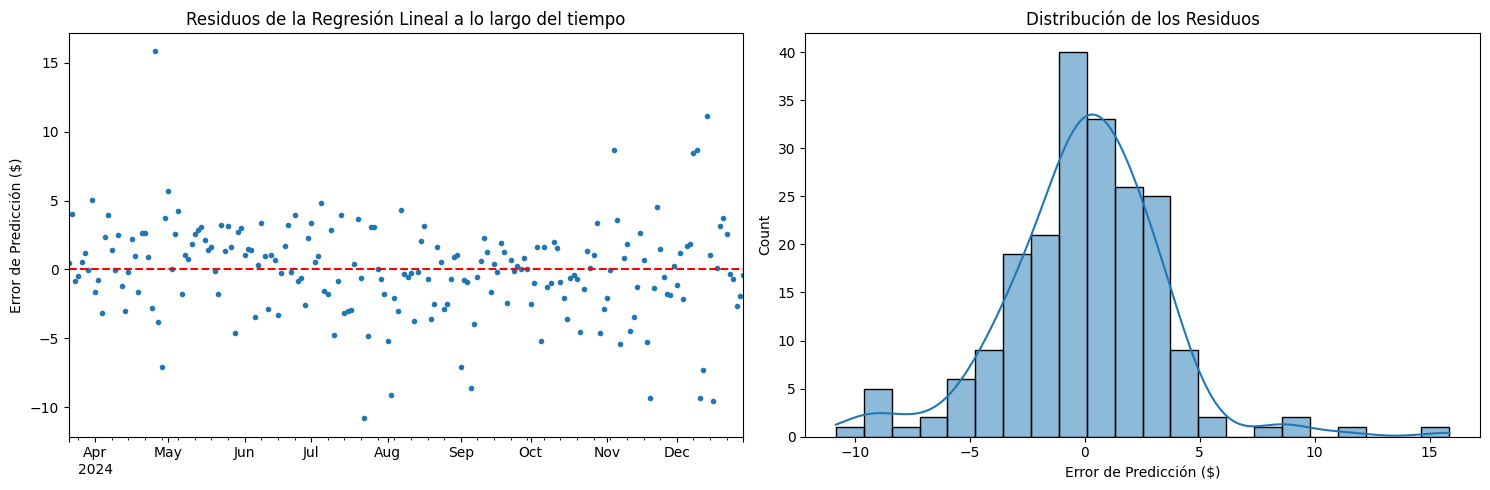


--- Verificación de Supuestos de Residuos ---
Media de los residuos: -0.0349
El supuesto de media cero en los residuos se cumple aproximadamente.
El gráfico de residuos vs. tiempo sugiere que la varianza no es constante (heterocedasticidad).


In [93]:
# Calcular métricas de rendimiento en escala de PRECIOS para Google creo
lr_mse = mean_squared_error(real_prices, lr_predictions_price)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(real_prices, lr_predictions_price)
lr_r2 = r2_score(real_prices, lr_predictions_price)
lr_mape = mean_absolute_percentage_error(real_prices, lr_predictions_price)

results['Regresion Lineal'] = {'MSE': lr_mse, 'RMSE': lr_rmse, 'MAE': lr_mae, 'R2': lr_r2, 'MAPE': lr_mape}

print("\n--- Evaluación del Modelo de Regresión Lineal ---")
print(f"MSE: {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"R²: {lr_r2:.4f}")
print(f"MAPE: {lr_mape:.2f}%")

# Análisis de Residuos
lr_residuals = real_prices - lr_predictions_price

plt.figure(figsize=(15, 5))

# Gráfico de Residuos vs. Tiempo
plt.subplot(1, 2, 1)
lr_residuals.plot(title='Residuos de la Regresión Lineal a lo largo del tiempo', style='.')
plt.axhline(y=0, color='r', linestyle='--')
plt.ylabel('Error de Predicción ($)')

# Histograma de los Residuos
plt.subplot(1, 2, 2)
sns.histplot(lr_residuals, kde=True)
plt.title('Distribución de los Residuos')
plt.xlabel('Error de Predicción ($)')

plt.tight_layout()
plt.show()

# Verificación de supuestos
print("\n--- Verificación de Supuestos de Residuos ---")
print(f"Media de los residuos: {lr_residuals.mean():.4f}")
# Un test de heterocedasticidad (Breusch-Pagan) podría añadirse aquí para mayor rigor.
if abs(lr_residuals.mean()) < 0.1:
    print("El supuesto de media cero en los residuos se cumple aproximadamente.")
else:
    print("Advertencia: La media de los residuos no es cercana a cero.")
print("El gráfico de residuos vs. tiempo sugiere que la varianza no es constante (heterocedasticidad).")

### MODELO ARIMMA

In [11]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.7 MB/s eta 0:00:00


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera

# Cargar los datos (asumiendo que X_train, X_test ya existen)
# Usaremos la serie de precios de cierre para GOOGL
train_data = X_train['GOOGL_Close']
test_data = X_test['GOOGL_Close']
full_data = pd.concat([train_data, test_data])

print("--- Análisis de la Serie Temporal para ARIMA: GOOGL ---")

--- Análisis de la Serie Temporal para ARIMA: GOOGL ---


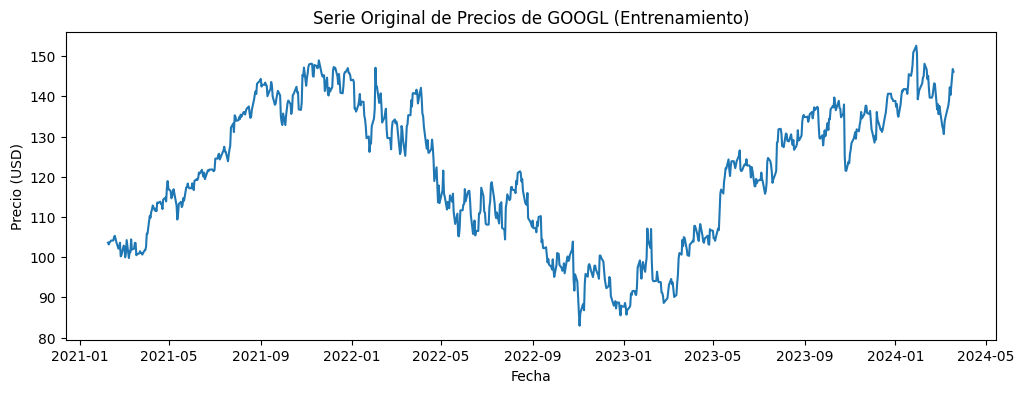


--- Test de Dickey-Fuller para la Serie Original ---
ADF Statistic: -1.7377
p-value: 0.4118
Resultado: La serie NO es estacionaria. Se requiere diferenciación (d > 0).

--- Aplicando primera diferenciación (d=1) ---


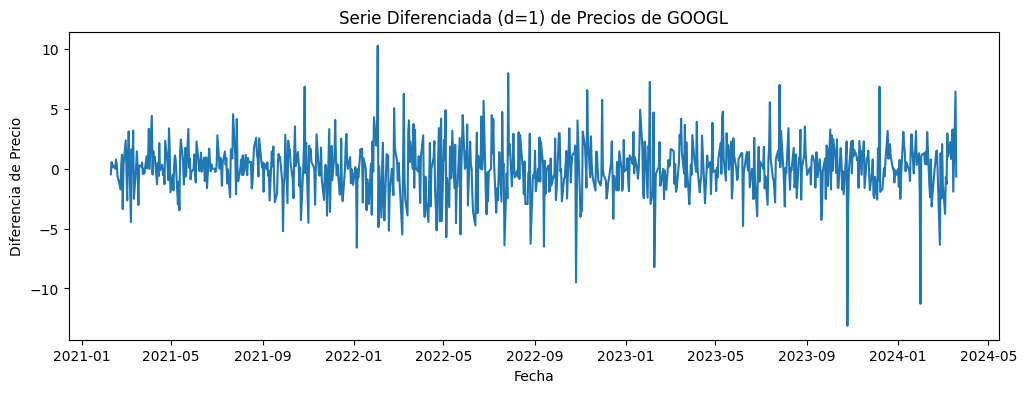


--- Test de Dickey-Fuller para la Serie Diferenciada ---
ADF Statistic: -28.8130
p-value: 0.0000
Resultado: La serie diferenciada ES estacionaria en media.


In [95]:
# 1. Análisis Visual de la Serie Original
plt.figure(figsize=(12, 4))
plt.plot(train_data)
plt.title('Serie Original de Precios de GOOGL (Entrenamiento)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.show()

# 2. Test de Estacionariedad en Media (Dickey-Fuller Aumentado)
print("\n--- Test de Dickey-Fuller para la Serie Original ---")
adf_result_orig = adfuller(train_data)
print(f'ADF Statistic: {adf_result_orig[0]:.4f}')
print(f'p-value: {adf_result_orig[1]:.4f}')
if adf_result_orig[1] > 0.05:
    print("Resultado: La serie NO es estacionaria. Se requiere diferenciación (d > 0).")
else:
    print("Resultado: La serie es estacionaria.")

# 3. Aplicar Diferenciación y Re-evaluar
print("\n--- Aplicando primera diferenciación (d=1) ---")
train_data_diff = train_data.diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(train_data_diff)
plt.title('Serie Diferenciada (d=1) de Precios de GOOGL')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de Precio')
plt.show()

print("\n--- Test de Dickey-Fuller para la Serie Diferenciada ---")
adf_result_diff = adfuller(train_data_diff)
print(f'ADF Statistic: {adf_result_diff[0]:.4f}')
print(f'p-value: {adf_result_diff[1]:.4f}')
if adf_result_diff[1] <= 0.05:
    print("Resultado: La serie diferenciada ES estacionaria en media.")
else:
    print("Resultado: La serie diferenciada aún no es estacionaria. Se podría requerir más diferenciación.")

In [96]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import itertools # Librería para crear combinaciones

# Ignorar advertencias de convergencia que pueden aparecer durante la búsqueda
warnings.filterwarnings("ignore")

# 1. Definir los rangos para p y q que queremos probar
p_range = range(0, 6) # Probará de 0 a 5 para el término AR
q_range = range(0, 6) # Probará de 0 a 5 para el término MA
d = 1 # Ya determinado por el test de Dickey-Fuller

# Crear todas las combinaciones posibles de (p, d, q)
pdq_combinations = list(itertools.product(p_range, [d], q_range))

# 2. Bucle para encontrar el mejor modelo
print("\n--- Búsqueda Manual del Mejor Modelo ARIMA basado en AIC ---")
best_aic = float('inf')
best_pdq = None
best_model = None

for pdq in pdq_combinations:
    # Evitar modelos triviales como (0,1,0) si queremos más complejidad
    if pdq[0] == 0 and pdq[2] == 0:
        continue

    try:
        model = ARIMA(train_data, order=pdq).fit()
        print(f'Probando ARIMA{pdq}... AIC: {model.aic:.2f}')
        if model.aic < best_aic:
            best_aic = model.aic
            best_pdq = pdq
            best_model = model

    except Exception as e:
        # Algunas combinaciones pueden fallar, las ignoramos
        continue

print("\n--- Mejor Modelo Encontrado ---")
print(f"Mejor Orden ARIMA(p,d,q): {best_pdq}")
print(f"Mejor AIC: {best_aic:.2f}")

# Guardamos el mejor modelo ajustado
best_arima_fit = best_model


--- Búsqueda Manual del Mejor Modelo ARIMA basado en AIC ---
Probando ARIMA(0, 1, 1)... AIC: 3639.33
Probando ARIMA(0, 1, 2)... AIC: 3641.11
Probando ARIMA(0, 1, 3)... AIC: 3639.43
Probando ARIMA(0, 1, 4)... AIC: 3641.34
Probando ARIMA(0, 1, 5)... AIC: 3641.95
Probando ARIMA(1, 1, 0)... AIC: 3639.34
Probando ARIMA(1, 1, 1)... AIC: 3636.52
Probando ARIMA(1, 1, 2)... AIC: 3638.05
Probando ARIMA(1, 1, 3)... AIC: 3639.35
Probando ARIMA(1, 1, 4)... AIC: 3640.80
Probando ARIMA(1, 1, 5)... AIC: 3642.01
Probando ARIMA(2, 1, 0)... AIC: 3641.16
Probando ARIMA(2, 1, 1)... AIC: 3638.02
Probando ARIMA(2, 1, 2)... AIC: 3640.45
Probando ARIMA(2, 1, 3)... AIC: 3640.55
Probando ARIMA(2, 1, 4)... AIC: 3642.36
Probando ARIMA(2, 1, 5)... AIC: 3642.79
Probando ARIMA(3, 1, 0)... AIC: 3639.90
Probando ARIMA(3, 1, 1)... AIC: 3639.40
Probando ARIMA(3, 1, 2)... AIC: 3640.66
Probando ARIMA(3, 1, 3)... AIC: 3638.38
Probando ARIMA(3, 1, 4)... AIC: 3640.39
Probando ARIMA(3, 1, 5)... AIC: 3635.25
Probando ARIMA(4, 


--- Diagnóstico de Residuos del Mejor Modelo ARIMA ---
Resumen del Modelo Seleccionado:
                               SARIMAX Results                                
Dep. Variable:            GOOGL_Close   No. Observations:                  812
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1806.782
Date:                Sun, 29 Jun 2025   AIC                           3629.564
Time:                        19:57:56   BIC                           3667.150
Sample:                    02-08-2021   HQIC                          3643.993
                         - 03-19-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8991      0.097     -9.243      0.000      -1.090      -0.708
ar.L2          0.5493      0.179      3.06

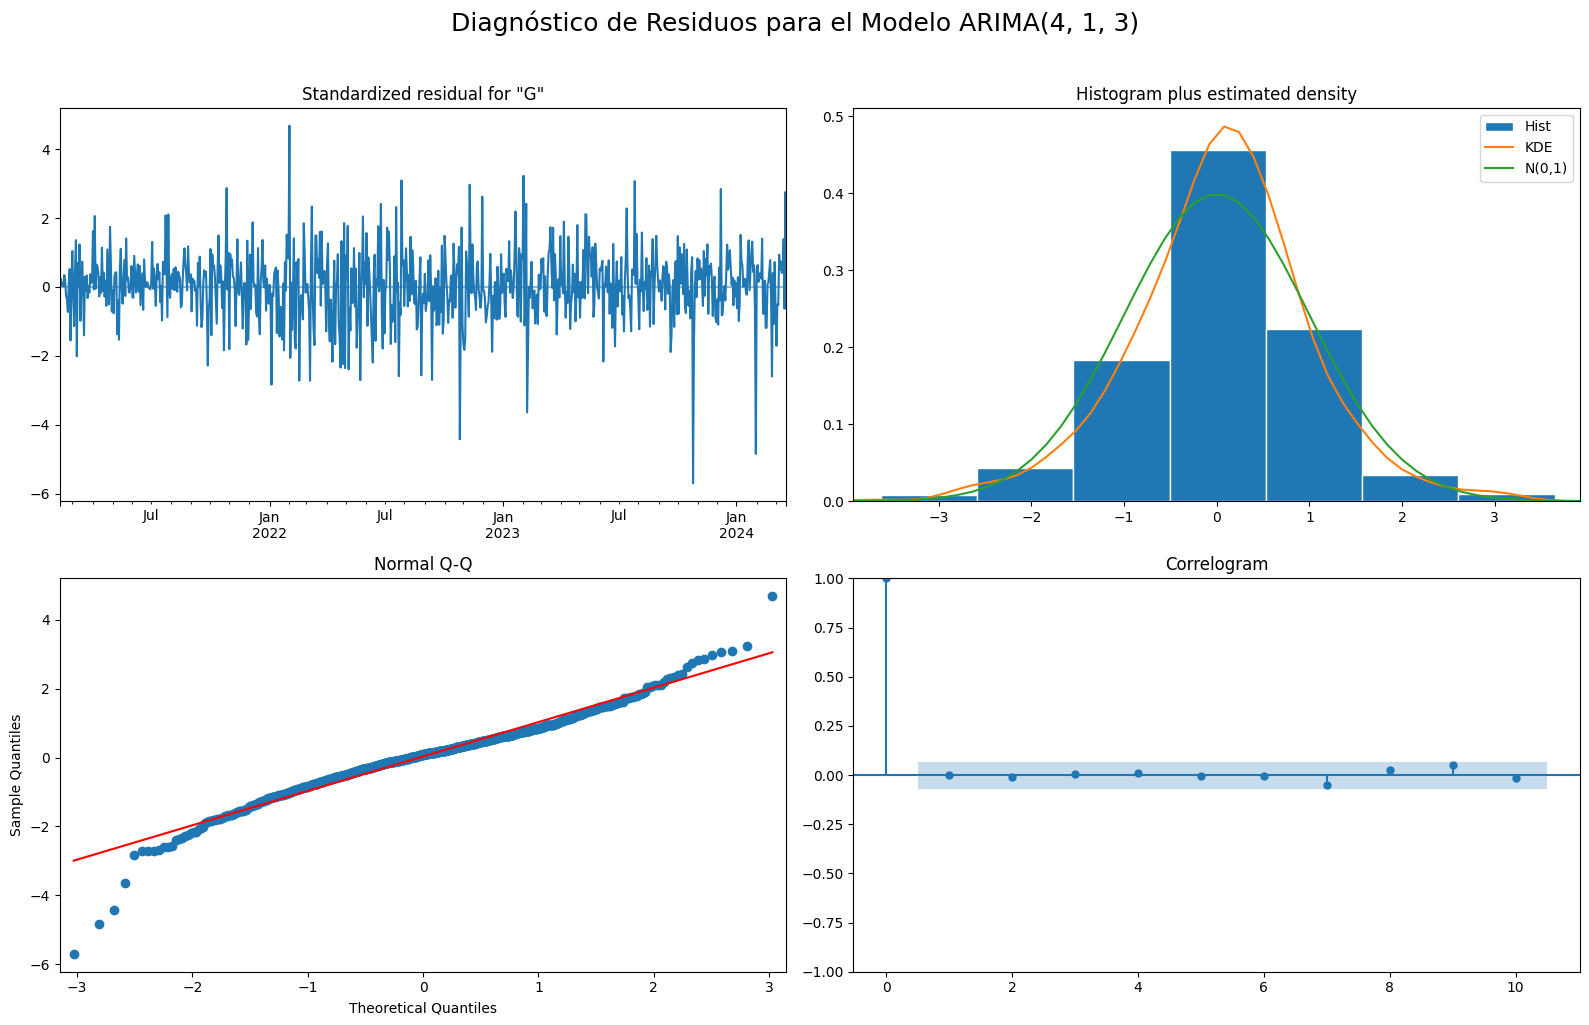


--- Pruebas Estadísticas Formales sobre los Residuos ---

Prueba de Normalidad (Jarque-Bera):
  - Estadístico JB: 6065091.11
  - p-value: 0.0000
  - Conclusión (α=5%): Se rechaza la hipótesis nula. Los residuos NO siguen una distribución normal.

Prueba de Autocorrelación de Residuos (Ljung-Box):
  - p-value para lag=10: 1.0000
  - Conclusión (α=5%): No hay evidencia de autocorrelación en los residuos. El modelo captura bien la estructura temporal.


In [97]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import seaborn as sns

print("\n--- Diagnóstico de Residuos del Mejor Modelo ARIMA ---")

# 1. Resumen estadístico del modelo
print("Resumen del Modelo Seleccionado:")
print(best_arima_fit.summary())

# 2. Gráficos de diagnóstico estándar
print("\nGenerando gráficos de diagnóstico de residuos...")
best_arima_fit.plot_diagnostics(figsize=(16, 10))
plt.suptitle(f"Diagnóstico de Residuos para el Modelo ARIMA{best_pdq}", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# Extraer los residuos para pruebas formales
residuals = best_arima_fit.resid

# 3. Pruebas estadísticas formales sobre los residuos
print("\n--- Pruebas Estadísticas Formales sobre los Residuos ---")

# --- CORRECCIÓN AQUÍ ---
# Test de Normalidad (Jarque-Bera) - Versión compatible con scipy moderno
# Ahora solo recoge los 2 valores que la función devuelve: estadístico y p-value.
jb_stat, jb_p_value = jarque_bera(residuals)
print(f"\nPrueba de Normalidad (Jarque-Bera):")
print(f"  - Estadístico JB: {jb_stat:.2f}")
print(f"  - p-value: {jb_p_value:.4f}")
if jb_p_value > 0.05:
    print("  - Conclusión (α=5%): No se rechaza la hipótesis nula. Los residuos parecen seguir una distribución normal.")
else:
    print("  - Conclusión (α=5%): Se rechaza la hipótesis nula. Los residuos NO siguen una distribución normal.")

# Test de Autocorrelación (Ljung-Box)
# Probamos con un lag de 10, que es un estándar común
ljung_box_result = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
lb_p_value = ljung_box_result['lb_pvalue'].iloc[0]
print(f"\nPrueba de Autocorrelación de Residuos (Ljung-Box):")
print(f"  - p-value para lag=10: {lb_p_value:.4f}")
if lb_p_value > 0.05:
    print("  - Conclusión (α=5%): No hay evidencia de autocorrelación en los residuos. El modelo captura bien la estructura temporal.")
else:
    print("  - Conclusión (α=5%): Hay evidencia de autocorrelación residual. El modelo podría mejorarse.")

In [98]:
# 1. Generación de Predicciones y Pronósticos
print("\n--- Generando Predicciones y Pronósticos a Futuro ---")

# Definir el número de pasos para predecir (tamaño del test set) y para pronosticar (2 meses)
n_test = len(test_data)
n_forecast = 60  # Aproximadamente 2 meses de días de negociación

# Usamos .get_forecast() que es el método recomendado para predicciones fuera de muestra
forecast_result = best_arima_fit.get_forecast(steps=n_test + n_forecast)

# 2. Extraer las predicciones para el período de prueba
arima_predictions_price = forecast_result.predicted_mean[:n_test]
arima_predictions_price.index = test_data.index  # Alinear con el índice de fechas del test set

# 3. Extraer el pronóstico a futuro y los intervalos de confianza
arima_forecast_price = forecast_result.predicted_mean[n_test:]
conf_int = forecast_result.conf_int(alpha=0.05)  # Intervalo de confianza del 95%
future_conf_int = conf_int.iloc[n_test:]

# Crear las fechas para el pronóstico
forecast_dates = pd.date_range(start=test_data.index[-1] + pd.DateOffset(days=1), periods=n_forecast)
arima_forecast_price.index = forecast_dates
future_conf_int.index = forecast_dates

# 4. Crear tabla de predicciones vs. reales para el conjunto de prueba
arima_test_table = pd.DataFrame({
    'Precio_Real': test_data,
    'Prediccion_ARIMA': arima_predictions_price
})

print("\n--- Muestra de la Tabla de Predicciones ARIMA (Conjunto de Prueba) ---")
print(arima_test_table.head())

# 5. Crear tabla de pronósticos a futuro
arima_forecast_table = pd.DataFrame({
    'Pronostico_ARIMA': arima_forecast_price,
    'Limite_Inferior_95%': future_conf_int.iloc[:, 0],
    'Limite_Superior_95%': future_conf_int.iloc[:, 1]
})
print("\n--- Muestra de la Tabla de Pronósticos ARIMA (Futuro) ---")
print(arima_forecast_table.head())


--- Generando Predicciones y Pronósticos a Futuro ---

--- Muestra de la Tabla de Predicciones ARIMA (Conjunto de Prueba) ---
            Precio_Real  Prediccion_ARIMA
2024-03-20     147.8533        146.369521
2024-03-21     146.7201        145.512951
2024-03-22     149.8712        145.411303
2024-03-25     149.1754        145.237214
2024-03-26     149.7718        144.677815

--- Muestra de la Tabla de Pronósticos ARIMA (Futuro) ---
            Pronostico_ARIMA  Limite_Inferior_95%  Limite_Superior_95%
2024-12-31        144.005478            98.070959           189.939997
2025-01-01        144.085970            98.042700           190.129240
2025-01-02        144.002087            97.850366           190.153807
2025-01-03        144.073397            97.812974           190.333820
2025-01-04        144.027919            97.659909           190.395929



--- Evaluación Final del Modelo ARIMA ---
MSE:  754.05
RMSE: 27.46 (Error promedio en USD, penalizando más los errores grandes)
MAE:  24.89 (Error promedio en USD)
R²:   -4.6980 (Proporción de la varianza explicada)
MAPE: 14.34% (Error porcentual promedio)


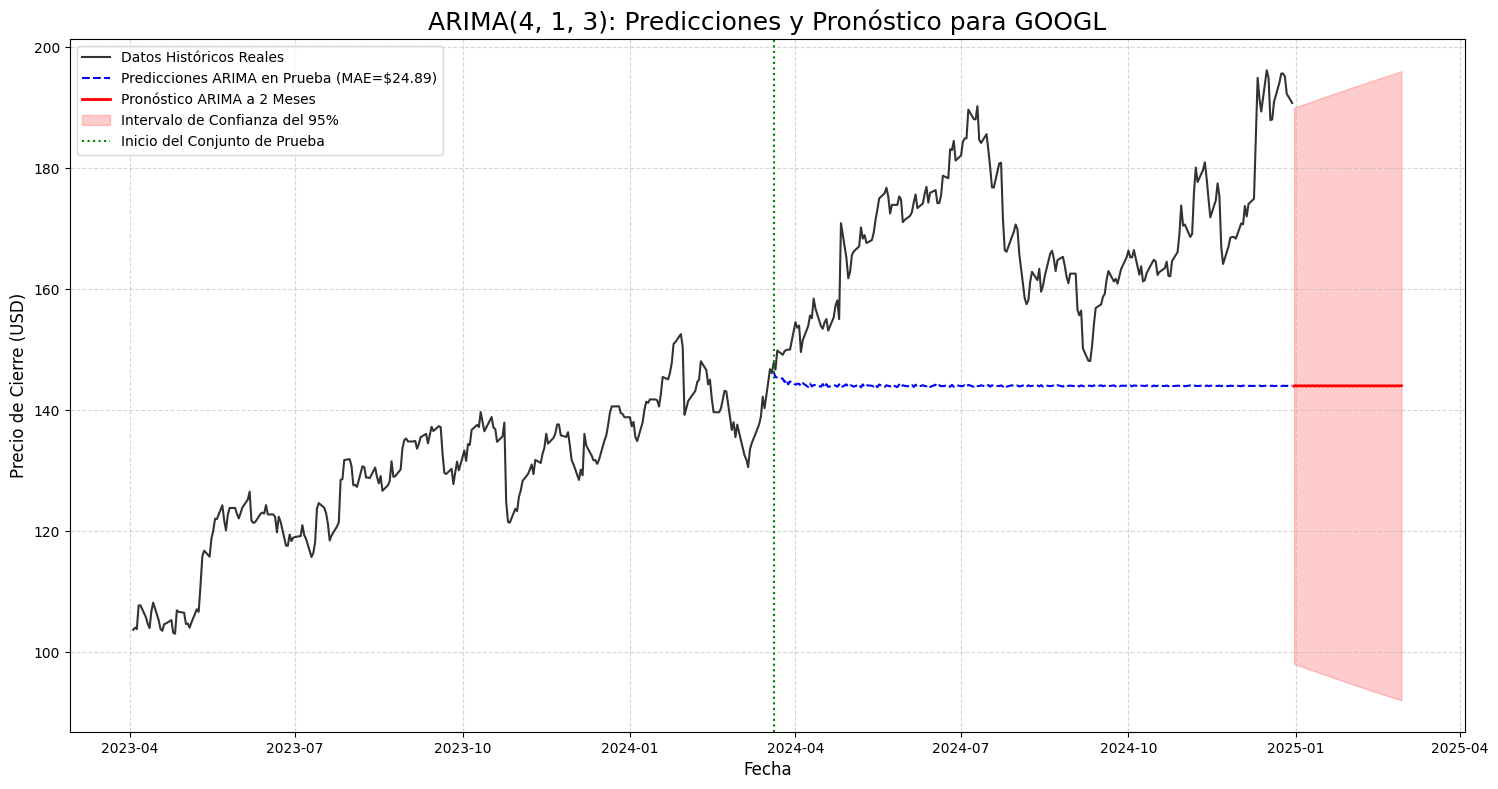

In [99]:
# 1. Calcular métricas de rendimiento en escala de PRECIOS
arima_mse = mean_squared_error(test_data, arima_predictions_price)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data, arima_predictions_price)
arima_r2 = r2_score(test_data, arima_predictions_price)
arima_mape = mean_absolute_percentage_error(test_data, arima_predictions_price)

# Guardar los resultados para la tabla comparativa final
results['ARIMA'] = {'MSE': arima_mse, 'RMSE': arima_rmse, 'MAE': arima_mae, 'R2': arima_r2, 'MAPE': arima_mape}

print("\n--- Evaluación Final del Modelo ARIMA ---")
print(f"MSE:  {arima_mse:.2f}")
print(f"RMSE: {arima_rmse:.2f} (Error promedio en USD, penalizando más los errores grandes)")
print(f"MAE:  {arima_mae:.2f} (Error promedio en USD)")
print(f"R²:   {arima_r2:.4f} (Proporción de la varianza explicada)")
print(f"MAPE: {arima_mape:.2f}% (Error porcentual promedio)")

# 2. Visualización Final (Histórico + Predicciones en Prueba + Pronóstico a Futuro)
plt.figure(figsize=(18, 9))

# Datos históricos (enfocados en el período más reciente para mayor claridad)
plt.plot(full_data.index[-len(test_data)-252:], full_data[-len(test_data)-252:], label='Datos Históricos Reales', color='black', alpha=0.8)

# Predicciones sobre el conjunto de prueba
plt.plot(arima_predictions_price.index, arima_predictions_price, label=f'Predicciones ARIMA en Prueba (MAE=${arima_mae:.2f})', color='blue', linestyle='--')

# Pronóstico a futuro
plt.plot(arima_forecast_price.index, arima_forecast_price, label='Pronóstico ARIMA a 2 Meses', color='red', linewidth=2)
plt.fill_between(forecast_dates,
                 future_conf_int.iloc[:, 0],
                 future_conf_int.iloc[:, 1],
                 color='red', alpha=0.2, label='Intervalo de Confianza del 95%')

plt.axvline(test_data.index[0], color='green', linestyle=':', label='Inicio del Conjunto de Prueba')
plt.title(f'ARIMA{best_pdq}: Predicciones y Pronóstico para GOOGL', fontsize=18)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [100]:
# Lista de modelos a probar
ml_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Iterar, entrenar y evaluar cada modelo
for name, model in ml_models.items():
    print(f"\n--- Entrenando Modelo: {name} ---")

    # Entrenar
    model.fit(X_train, y_train_googl)

    # Predecir retornos y convertir a precios
    predictions_return = model.predict(X_test)
    predictions_price = X_test['GOOGL_Close'] * (1 + predictions_return)

    # Evaluar
    mse = mean_squared_error(real_prices, predictions_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real_prices, predictions_price)
    r2 = r2_score(real_prices, predictions_price)
    mape = mean_absolute_percentage_error(real_prices, predictions_price)

    results[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

    print(f"--- Evaluación de {name} ---")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

    # Guardar predicciones para el gráfico final
    if name == "Random Forest":
        rf_predictions_price = predictions_price
    else:
        gb_predictions_price = predictions_price


--- Entrenando Modelo: Random Forest ---
--- Evaluación de Random Forest ---
MSE: 43.05, RMSE: 6.56, MAE: 5.78, R²: 0.6749, MAPE: 3.38%

--- Entrenando Modelo: Gradient Boosting ---
--- Evaluación de Gradient Boosting ---
MSE: 35.91, RMSE: 5.99, MAE: 5.03, R²: 0.7288, MAPE: 2.94%




--- Tabla Comparativa Final de Rendimiento de Modelos ---
                          MSE       RMSE        MAE        R2       MAPE
Regresion Lineal    11.734874   3.425620   2.464030  0.911391   1.446053
Gradient Boosting   35.911321   5.992606   5.029520  0.728836   2.935738
Random Forest       43.047990   6.561097   5.783452  0.674947   3.376229
ARIMA              754.054363  27.460050  24.890941 -4.697961  14.335126


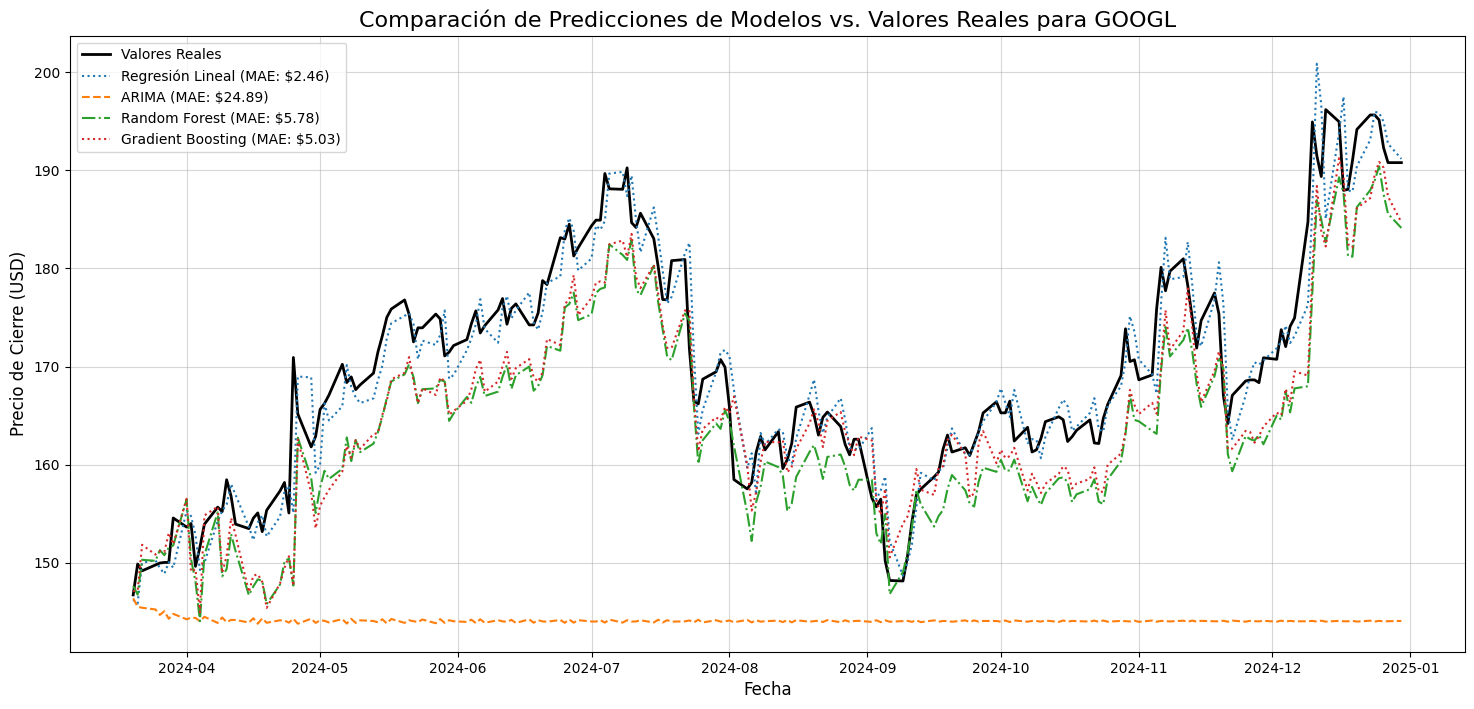

In [23]:
# Crear DataFrame con todos los resultados
results_df = pd.DataFrame(results).T.sort_values(by='MSE')

print("\n\n--- Tabla Comparativa Final de Rendimiento de Modelos ---")
print(results_df)

# Gráfico final de comparación de pronósticos
plt.figure(figsize=(18, 8))
plt.plot(real_prices.index, real_prices, label='Valores Reales', color='black', linewidth=2)
plt.plot(lr_predictions_price.index, lr_predictions_price, label=f'Regresión Lineal (MAE: ${lr_mae:.2f})', linestyle=':')
plt.plot(arima_predictions_price.index, arima_predictions_price, label=f'ARIMA (MAE: ${arima_mae:.2f})', linestyle='--')
plt.plot(rf_predictions_price.index, rf_predictions_price, label=f'Random Forest (MAE: ${results["Random Forest"]["MAE"]:.2f})', linestyle='-.')
plt.plot(gb_predictions_price.index, gb_predictions_price, label=f'Gradient Boosting (MAE: ${results["Gradient Boosting"]["MAE"]:.2f})', linestyle=':')

plt.title('Comparación de Predicciones de Modelos vs. Valores Reales para GOOGL', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [101]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Almacenaremos los modelos entrenados en un diccionario para usarlos después
trained_ml_models = {}

# Lista de modelos a probar
ml_models_config = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Iterar, entrenar y evaluar cada modelo
for name, model in ml_models_config.items():
    print(f"\n--- Entrenando Modelo: {name} ---")

    # Entrenar
    model.fit(X_train, y_train_googl)
    trained_ml_models[name] = model # Guardar el modelo entrenado

    # Predecir retornos y convertir a precios
    predictions_return = model.predict(X_test)
    predictions_price = X_test['GOOGL_Close'] * (1 + predictions_return)

    # Evaluar
    mse = mean_squared_error(real_prices, predictions_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real_prices, predictions_price)
    r2 = r2_score(real_prices, predictions_price)
    mape = mean_absolute_percentage_error(real_prices, predictions_price)

    results[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

    print(f"--- Evaluación de {name} ---")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# --- Función para Pronóstico de Escenario ---
def scenario_forecast(model, last_known_values, scenario_values):
    """
    Realiza un pronóstico para el día siguiente basado en un escenario específico.

    Args:
        model: El modelo de ML entrenado.
        last_known_values (pd.Series): La última fila de datos conocidos (del X_test).
        scenario_values (dict): Un diccionario con las variables y valores del escenario.

    Returns:
        float: El precio pronosticado para el día siguiente.
    """
    # Crear una copia de los últimos datos conocidos para no modificarlos
    scenario_input = last_known_values.copy()

    # Actualizar los valores con los del escenario
    for var, val in scenario_values.items():
        if var in scenario_input.index:
            scenario_input[var] = val
        else:
            print(f"Advertencia: La variable '{var}' no se encuentra en las características del modelo.")

    # Crear los lags para el escenario
    # Asumimos que los valores del escenario son para el día actual (t-1)
    # y los lags anteriores (t-2, t-3...) se mantienen
    for var, val in scenario_values.items():
        for i in range(1, 6): # Asumiendo 5 lags
             # El lag_1 es el valor del escenario, el lag_2 es el antiguo lag_1, etc.
            if i == 1 and f'{var}_lag_{i}' in scenario_input.index:
                scenario_input[f'{var}_lag_{i}'] = val
            elif f'{var}_lag_{i}' in scenario_input.index:
                 scenario_input[f'{var}_lag_{i}'] = last_known_values[f'{var}_lag_{i-1}']

    # Realizar la predicción del retorno
    predicted_return = model.predict(scenario_input.values.reshape(1, -1))[0]

    # Calcular el precio pronosticado
    last_price = scenario_input['GOOGL_Close']
    predicted_price = last_price * (1 + predicted_return)

    return predicted_price

print("\nFunción 'scenario_forecast' creada y lista para usar.")


--- Entrenando Modelo: Random Forest ---
--- Evaluación de Random Forest ---
MSE: 43.05, RMSE: 6.56, MAE: 5.78, R²: 0.6749, MAPE: 3.38%

--- Entrenando Modelo: Gradient Boosting ---
--- Evaluación de Gradient Boosting ---
MSE: 35.91, RMSE: 5.99, MAE: 5.03, R²: 0.7288, MAPE: 2.94%

Función 'scenario_forecast' creada y lista para usar.



--- Generando Pronósticos Puntuales basados en Escenarios ---
El último precio conocido de GOOGL es: $190.79

--- Resultados de Escenarios Predefinidos (usando Random Forest) ---
Escenario Bajista (VIX alto, tasas altas): Precio pronosticado = $183.90
Escenario Alcista (VIX bajo, tasas bajas): Precio pronosticado = $186.32

--- Escenario Interactivo: Introduce tus propios valores ---
Introduce el valor para Treasury_10Y (ej. 4.2): 3.9
Introduce el valor para VIX (ej. 15.0): 15
Introduce el valor para Inflacion_T5YIE (ej. 2.2): 2.2

--- Resultado del Escenario del Usuario ---
Bajo tus condiciones, el precio pronosticado para GOOGL es: $184.03


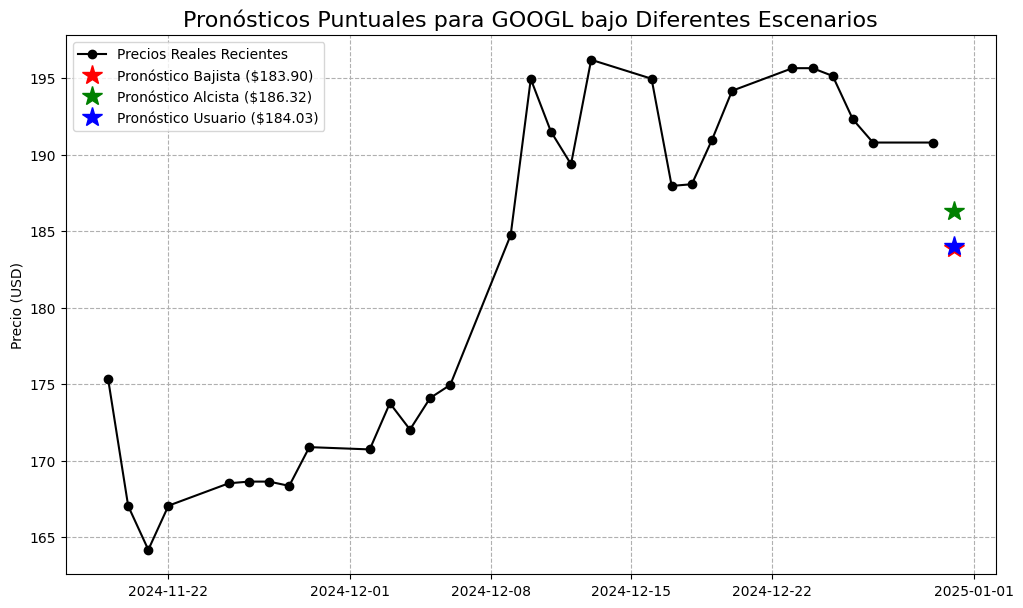

In [102]:
# Tomamos la última fila de datos de prueba como base para nuestros escenarios
last_data_point = X_test.iloc[-1]
last_real_price = last_data_point['GOOGL_Close']

print(f"\n--- Generando Pronósticos Puntuales basados en Escenarios ---")
print(f"El último precio conocido de GOOGL es: ${last_real_price:.2f}")

# --- Escenario 1: Predefinido - "Alta Volatilidad y Aumento de Tasas" (Bajista) ---
scenario_bajista = {
    'Treasury_10Y': 4.8,  # Aumento de tasas
    'VIX': 25.0,         # Aumento del miedo
    'Inflacion_T5YIE': 2.5 # Aumento de la inflación
}

# --- Escenario 2: Predefinido - "Baja Volatilidad y Caída de Tasas" (Alcista) ---
scenario_alcista = {
    'Treasury_10Y': 3.5, # Caída de tasas
    'VIX': 12.0,         # Mercado en calma
    'Inflacion_T5YIE': 2.0 # Inflación controlada
}

# Calcular pronósticos para los escenarios predefinidos con el mejor modelo (Random Forest)
rf_model = trained_ml_models['Random Forest']
forecast_bajista = scenario_forecast(rf_model, last_data_point, scenario_bajista)
forecast_alcista = scenario_forecast(rf_model, last_data_point, scenario_alcista)

print("\n--- Resultados de Escenarios Predefinidos (usando Random Forest) ---")
print(f"Escenario Bajista (VIX alto, tasas altas): Precio pronosticado = ${forecast_bajista:.2f}")
print(f"Escenario Alcista (VIX bajo, tasas bajas): Precio pronosticado = ${forecast_alcista:.2f}")

# --- Escenario 3: Interactivo - Pídele los valores al usuario ---
print("\n--- Escenario Interactivo: Introduce tus propios valores ---")
try:
    user_treasury = float(input("Introduce el valor para Treasury_10Y (ej. 4.2): "))
    user_vix = float(input("Introduce el valor para VIX (ej. 15.0): "))
    user_inflation = float(input("Introduce el valor para Inflacion_T5YIE (ej. 2.2): "))

    scenario_usuario = {
        'Treasury_10Y': user_treasury,
        'VIX': user_vix,
        'Inflacion_T5YIE': user_inflation
    }

    forecast_usuario = scenario_forecast(rf_model, last_data_point, scenario_usuario)
    print("\n--- Resultado del Escenario del Usuario ---")
    print(f"Bajo tus condiciones, el precio pronosticado para GOOGL es: ${forecast_usuario:.2f}")

except ValueError:
    print("Entrada inválida. Por favor, introduce números.")

# --- Gráfico con Pronósticos Puntuales ---
plt.figure(figsize=(12, 7))
# Graficamos los últimos 30 días de precios reales para dar contexto
plt.plot(real_prices[-30:], label='Precios Reales Recientes', color='black', marker='o')

# Añadir los pronósticos puntuales como estrellas
plt.plot(real_prices.index[-1] + pd.Timedelta(days=1), forecast_bajista, 'r*', markersize=15, label=f'Pronóstico Bajista (${forecast_bajista:.2f})')
plt.plot(real_prices.index[-1] + pd.Timedelta(days=1), forecast_alcista, 'g*', markersize=15, label=f'Pronóstico Alcista (${forecast_alcista:.2f})')
if 'forecast_usuario' in locals():
    plt.plot(real_prices.index[-1] + pd.Timedelta(days=1), forecast_usuario, 'b*', markersize=15, label=f'Pronóstico Usuario (${forecast_usuario:.2f})')

plt.title('Pronósticos Puntuales para GOOGL bajo Diferentes Escenarios', fontsize=16)
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


--- Generando Pronósticos Puntuales basados en Escenarios ---
El último precio conocido de GOOGL es: $190.79

--- Resultados de Escenarios Predefinidos (Comparativa) ---
Escenario  | Random Forest        | Gradient Boosting   
-----------------------------------------------------------------
Bajista    | $183.90              | $185.02              
Alcista    | $186.32              | $189.98              

--- Escenario Interactivo: Introduce tus propios valores ---
Introduce el valor para Treasury_10Y (ej. 4.2): 5
Introduce el valor para VIX (ej. 15.0): 14
Introduce el valor para Inflacion_T5YIE (ej. 2.2): 2

--- Resultado del Escenario del Usuario (Comparativa) ---
Modelo             | Precio Pronosticado
-----------------------------------
Random Forest      | $186.28
Gradient Boosting  | $190.29


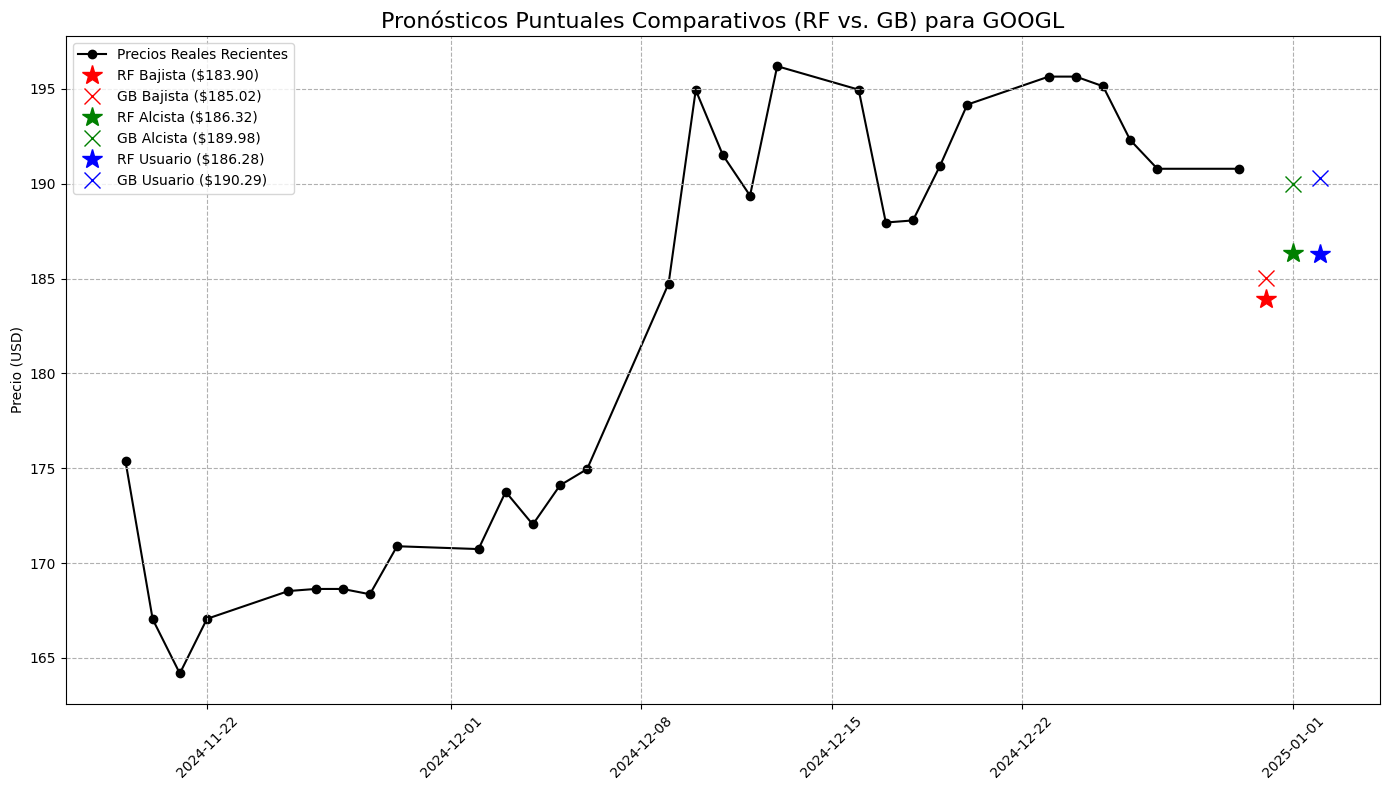

In [103]:
# Asegúrate de tener los modelos entrenados del paso anterior
# trained_ml_models['Random Forest'] y trained_ml_models['Gradient Boosting']

# Tomamos la última fila de datos de prueba como base para nuestros escenarios
last_data_point = X_test.iloc[-1]
last_real_price = last_data_point['GOOGL_Close']

print(f"\n--- Generando Pronósticos Puntuales basados en Escenarios ---")
print(f"El último precio conocido de GOOGL es: ${last_real_price:.2f}")

# --- Escenario 1: Predefinido - "Alta Volatilidad y Aumento de Tasas" (Bajista) ---
scenario_bajista = {
    'Treasury_10Y': 4.8,
    'VIX': 25.0,
    'Inflacion_T5YIE': 2.5
}

# --- Escenario 2: Predefinido - "Baja Volatilidad y Caída de Tasas" (Alcista) ---
scenario_alcista = {
    'Treasury_10Y': 3.5,
    'VIX': 12.0,
    'Inflacion_T5YIE': 2.0
}

# --- Calcular pronósticos para ambos modelos ---
rf_model = trained_ml_models['Random Forest']
gb_model = trained_ml_models['Gradient Boosting']

# Pronósticos de Random Forest
rf_forecast_bajista = scenario_forecast(rf_model, last_data_point, scenario_bajista)
rf_forecast_alcista = scenario_forecast(rf_model, last_data_point, scenario_alcista)

# Pronósticos de Gradient Boosting
gb_forecast_bajista = scenario_forecast(gb_model, last_data_point, scenario_bajista)
gb_forecast_alcista = scenario_forecast(gb_model, last_data_point, scenario_alcista)


print("\n--- Resultados de Escenarios Predefinidos (Comparativa) ---")
print(f"{'Escenario':<10} | {'Random Forest':<20} | {'Gradient Boosting':<20}")
print("-" * 65)
print(f"{'Bajista':<10} | ${rf_forecast_bajista:<19.2f} | ${gb_forecast_bajista:<20.2f}")
print(f"{'Alcista':<10} | ${rf_forecast_alcista:<19.2f} | ${gb_forecast_alcista:<20.2f}")


# --- Escenario 3: Interactivo - Pídele los valores al usuario ---
print("\n--- Escenario Interactivo: Introduce tus propios valores ---")
try:
    user_treasury = float(input("Introduce el valor para Treasury_10Y (ej. 4.2): "))
    user_vix = float(input("Introduce el valor para VIX (ej. 15.0): "))
    user_inflation = float(input("Introduce el valor para Inflacion_T5YIE (ej. 2.2): "))

    scenario_usuario = {
        'Treasury_10Y': user_treasury,
        'VIX': user_vix,
        'Inflacion_T5YIE': user_inflation
    }

    rf_forecast_usuario = scenario_forecast(rf_model, last_data_point, scenario_usuario)
    gb_forecast_usuario = scenario_forecast(gb_model, last_data_point, scenario_usuario)

    print("\n--- Resultado del Escenario del Usuario (Comparativa) ---")
    print(f"Modelo             | Precio Pronosticado")
    print("-" * 35)
    print(f"Random Forest      | ${rf_forecast_usuario:.2f}")
    print(f"Gradient Boosting  | ${gb_forecast_usuario:.2f}")

except ValueError:
    print("Entrada inválida. Por favor, introduce números.")


# --- Gráfico con Pronósticos Puntuales Comparativos ---
plt.figure(figsize=(14, 8))

# Graficamos los últimos 30 días de precios reales para dar contexto
plt.plot(real_prices[-30:], label='Precios Reales Recientes', color='black', marker='o', zorder=1)

# Añadir los pronósticos puntuales como estrellas
# Usaremos un pequeño desplazamiento en el eje Y para que no se solapen si son muy parecidos
offset = 0.5

# Escenario Bajista
plt.plot(real_prices.index[-1] + pd.Timedelta(days=1), rf_forecast_bajista, 'r*', markersize=15, label=f'RF Bajista (${rf_forecast_bajista:.2f})', zorder=2)
plt.plot(real_prices.index[-1] + pd.Timedelta(days=1), gb_forecast_bajista, 'rx', markersize=12, label=f'GB Bajista (${gb_forecast_bajista:.2f})', zorder=2)

# Escenario Alcista
plt.plot(real_prices.index[-1] + pd.Timedelta(days=2), rf_forecast_alcista, 'g*', markersize=15, label=f'RF Alcista (${rf_forecast_alcista:.2f})', zorder=2)
plt.plot(real_prices.index[-1] + pd.Timedelta(days=2), gb_forecast_alcista, 'gx', markersize=12, label=f'GB Alcista (${gb_forecast_alcista:.2f})', zorder=2)

# Escenario Usuario
if 'rf_forecast_usuario' in locals():
    plt.plot(real_prices.index[-1] + pd.Timedelta(days=3), rf_forecast_usuario, 'b*', markersize=15, label=f'RF Usuario (${rf_forecast_usuario:.2f})', zorder=2)
    plt.plot(real_prices.index[-1] + pd.Timedelta(days=3), gb_forecast_usuario, 'bx', markersize=12, label=f'GB Usuario (${gb_forecast_usuario:.2f})', zorder=2)

plt.title('Pronósticos Puntuales Comparativos (RF vs. GB) para GOOGL', fontsize=16)
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, linestyle='--')
plt.xticks(rotation=45) # Rotar las fechas para mejor legibilidad
plt.tight_layout()
plt.show()

In [104]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

print("\n--- Preparando datos para los modelos LSTM ---")

# --- CORRECCIÓN DEFINITIVA: Cargar el dataset usando la posición de la columna de fecha ---
try:
    df = pd.read_csv('dataset_completo_recolectado.csv', index_col=0, parse_dates=[0])
    df.sort_index(inplace=True)
    print("Dataset original cargado para la preparación de LSTM.")
except FileNotFoundError:
    print("Error: No se encontró 'dataset_completo_recolectado.csv'. Asegúrate de que el Módulo 1 se ha ejecutado.")
    exit()

# --- Función para crear secuencias ---
# Esta función es un poco diferente para cada caso (bivariado y multivariado)
def create_lstm_sequences(data, n_steps, n_features_out):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, :n_features_out]) # Salida flexible
    return np.array(X), np.array(y)

# Definir el número de pasos de tiempo (días) que el modelo mirará hacia atrás
n_steps = 60

# --- A. Datos para el Modelo Bivariante ---
print("\nPreparando datos bivariantes...")
df_biv = df[['GOOGL_Close', 'AMZN_Close']]

scaler_biv = MinMaxScaler(feature_range=(0, 1))
scaled_biv = scaler_biv.fit_transform(df_biv)

X_biv, y_biv = create_lstm_sequences(scaled_biv, n_steps, n_features_out=2)

# Usar el mismo tamaño de entrenamiento que en los modelos anteriores
train_size = len(X_train)
split_idx_biv = train_size

X_train_biv, X_test_biv = X_biv[:split_idx_biv], X_biv[split_idx_biv:]
y_train_biv, y_test_biv = y_biv[:split_idx_biv], y_biv[split_idx_biv:]

# --- B. Datos para el Modelo Multivariante ---
print("\nPreparando datos multivariantes...")
# Volvemos a crear df_multi_features para que la celda sea autocontenida
df_multi_features = df.copy()
# (Se asume que las columnas de retorno y volatilidad ya están en `df` o se calculan aquí)
# Para seguridad, vamos a recalcularlas si no existen
if 'GOOGL_Return_1d' not in df_multi_features.columns:
    for col in ['GOOGL_Close', 'AMZN_Close']:
        df_multi_features[f'{col}_Return_1d'] = df_multi_features[col].pct_change()
        df_multi_features[f'{col}_Volatility_20'] = df_multi_features[f'{col}_Return_1d'].rolling(window=20).std()
    df_multi_features.dropna(inplace=True)


scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler_multi.fit_transform(df_multi_features)

X_multi, y_multi = create_lstm_sequences(scaled_multi, n_steps, n_features_out=2)

# Recalcular el índice de división para el caso multivariante
train_size_multi = len(X_train)
split_idx_multi = train_size_multi

X_train_multi, X_test_multi = X_multi[:split_idx_multi], X_multi[split_idx_multi:]
y_train_multi, y_test_multi = y_multi[:split_idx_multi], y_multi[split_idx_multi:]


print("\nDatos para LSTM listos.")
print(f"Bivariado - X_train: {X_train_biv.shape}, X_test: {X_test_biv.shape}")
print(f"Multivariado - X_train: {X_train_multi.shape}, X_test: {X_test_multi.shape}")


--- Preparando datos para los modelos LSTM ---
Dataset original cargado para la preparación de LSTM.

Preparando datos bivariantes...

Preparando datos multivariantes...

Datos para LSTM listos.
Bivariado - X_train: (812, 60, 2), X_test: (170, 60, 2)
Multivariado - X_train: (812, 60, 11), X_test: (150, 60, 11)


In [105]:
print("\n--- Entrenando Modelo 5: LSTM Bivariado ---")

# Definir la arquitectura
model_bivariate = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(n_steps, 2)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=2) # Salida para GOOGL y AMZN
])
model_bivariate.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar (usamos pocas épocas para un ejemplo rápido, en la tesis podrías usar más)
model_bivariate.fit(X_train_biv, y_train_biv, epochs=25, batch_size=32, verbose=0)

# Predicción y Evaluación
predictions_biv_scaled = model_bivariate.predict(X_test_biv)
predictions_biv_price = scaler_biv.inverse_transform(predictions_biv_scaled)
real_prices_biv = scaler_biv.inverse_transform(y_test_biv)

# Métricas para GOOGL
mse_googl_biv = mean_squared_error(real_prices_biv[:, 0], predictions_biv_price[:, 0])
mae_googl_biv = mean_absolute_error(real_prices_biv[:, 0], predictions_biv_price[:, 0])
r2_googl_biv = r2_score(real_prices_biv[:, 0], predictions_biv_price[:, 0])
mape_googl_biv = mean_absolute_percentage_error(real_prices_biv[:, 0], predictions_biv_price[:, 0])

results['LSTM Bivariado'] = {'MSE': mse_googl_biv, 'RMSE': np.sqrt(mse_googl_biv), 'MAE': mae_googl_biv, 'R2': r2_googl_biv, 'MAPE': mape_googl_biv}
print("--- Evaluación LSTM Bivariado (GOOGL) ---")
print(f"MSE: {mse_googl_biv:.2f}, MAE: {mae_googl_biv:.2f}, R²: {r2_googl_biv:.4f}, MAPE: {mape_googl_biv:.2f}%")

# Guardar predicciones para el gráfico
lstm_biv_predictions_price = pd.Series(predictions_biv_price[:, 0], index=X_test.index[-len(predictions_biv_price):])


--- Entrenando Modelo 5: LSTM Bivariado ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
--- Evaluación LSTM Bivariado (GOOGL) ---
MSE: 39.51, MAE: 5.26, R²: 0.6450, MAPE: 3.02%



--- Entrenando y Evaluando el Modelo 5: LSTM Bivariado ---

Arquitectura del Modelo LSTM Bivariado:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,902 (120.71 KB)

 Trainable params: 30,902 (120.71 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento del modelo...
Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.1151 - val_loss: 0.0125
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0153 - val_loss: 0.0049
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0144 - val_loss: 0.0252
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0136 - val_loss: 0.0363
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0119 - val_loss: 0.0196
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0100 - val_loss: 0.0121
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0084 - val_loss: 0.0105
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0060 - val_loss: 0.0109
Epoch 10/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0055 - val_loss: 0.0080
Epoch 11/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 12/25
26/26 ━━━━

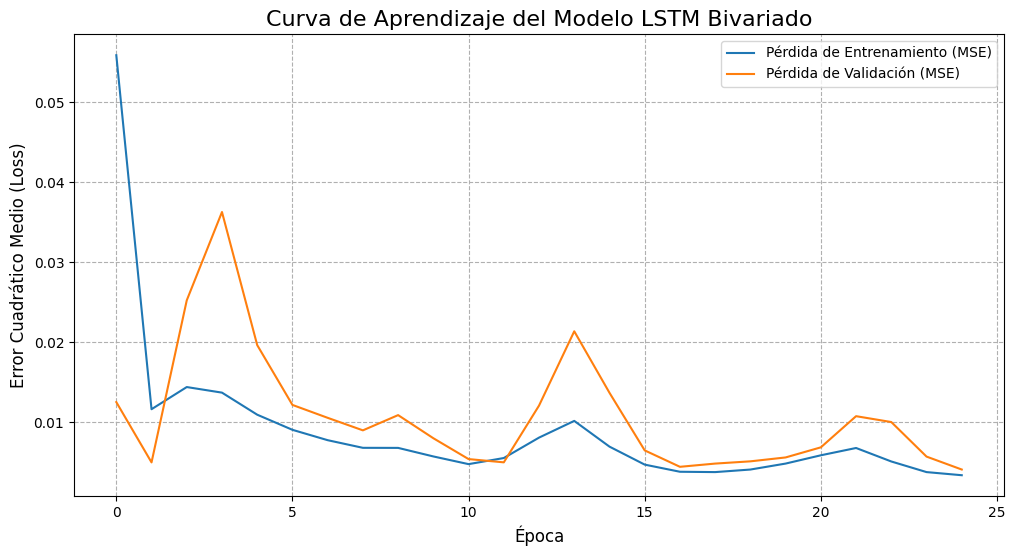


Realizando predicciones en el conjunto de prueba...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

--- Evaluación Final del Modelo LSTM Bivariado ---

Para GOOGL:
  MSE: 66.07
  RMSE: 8.13
  MAE: 6.97
  R²: 0.4064
  MAPE: 3.97%

Para AMZN:
  MSE: 67.46
  RMSE: 8.21
  MAE: 6.30
  R²: 0.7374
  MAPE: 3.21%


In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

print("\n--- Entrenando y Evaluando el Modelo 5: LSTM Bivariado ---")

# 1. Definir la Arquitectura del Modelo
# Las dimensiones de entrada y salida se toman de los datos ya preparados
model_bivariate = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_biv.shape[1], X_train_biv.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=y_train_biv.shape[1]) # units=2 para predecir GOOGL y AMZN
])

# 2. Compilar el Modelo
model_bivariate.compile(optimizer='adam', loss='mean_squared_error')

# Mostrar un resumen de la arquitectura del modelo
print("\nArquitectura del Modelo LSTM Bivariado:")
model_bivariate.summary()

# 3. Entrenar el Modelo
# Se usan 25 épocas para un entrenamiento rápido. Considerar aumentar a 50 para la tesis final.
# Se utiliza el conjunto de prueba como datos de validación para monitorear el sobreajuste.
print("\nIniciando entrenamiento del modelo...")
history_bivariate = model_bivariate.fit(
    X_train_biv,
    y_train_biv,
    epochs=25,
    batch_size=32,
    validation_data=(X_test_biv, y_test_biv),
    verbose=1,
    shuffle=False # Es importante no barajar los datos en series temporales
)
print("Entrenamiento completado.")

# 4. Visualizar la Curva de Aprendizaje
plt.figure(figsize=(12, 6))
plt.plot(history_bivariate.history['loss'], label='Pérdida de Entrenamiento (MSE)')
plt.plot(history_bivariate.history['val_loss'], label='Pérdida de Validación (MSE)')
plt.title('Curva de Aprendizaje del Modelo LSTM Bivariado', fontsize=16)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Error Cuadrático Medio (Loss)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


# 5. Realizar Predicciones y Evaluar el Rendimiento
print("\nRealizando predicciones en el conjunto de prueba...")
predictions_biv_scaled = model_bivariate.predict(X_test_biv)

# Revertir la normalización para que las predicciones y los valores reales estén en escala de precios
predictions_biv_price = scaler_biv.inverse_transform(predictions_biv_scaled)
real_prices_biv = scaler_biv.inverse_transform(y_test_biv)

# --- Métricas para GOOGL ---
y_true_googl = real_prices_biv[:, 0]
y_pred_googl = predictions_biv_price[:, 0]
mse_googl_biv = mean_squared_error(y_true_googl, y_pred_googl)
rmse_googl_biv = np.sqrt(mse_googl_biv)
mae_googl_biv = mean_absolute_error(y_true_googl, y_pred_googl)
r2_googl_biv = r2_score(y_true_googl, y_pred_googl)
mape_googl_biv = mean_absolute_percentage_error(y_true_googl, y_pred_googl)

# --- Métricas para AMZN ---
y_true_amzn = real_prices_biv[:, 1]
y_pred_amzn = predictions_biv_price[:, 1]
mse_amzn_biv = mean_squared_error(y_true_amzn, y_pred_amzn)
rmse_amzn_biv = np.sqrt(mse_amzn_biv)
mae_amzn_biv = mean_absolute_error(y_true_amzn, y_pred_amzn)
r2_amzn_biv = r2_score(y_true_amzn, y_pred_amzn)
mape_amzn_biv = mean_absolute_percentage_error(y_true_amzn, y_pred_amzn)

# Guardar resultados en el diccionario principal para la tabla comparativa
results['LSTM Bivariado (GOOGL)'] = {'MSE': mse_googl_biv, 'RMSE': rmse_googl_biv, 'MAE': mae_googl_biv, 'R2': r2_googl_biv, 'MAPE': mape_googl_biv}
results['LSTM Bivariado (AMZN)'] = {'MSE': mse_amzn_biv, 'RMSE': rmse_amzn_biv, 'MAE': mae_amzn_biv, 'R2': r2_amzn_biv, 'MAPE': mape_amzn_biv}

# --- Imprimir Resultados Finales ---
print("\n--- Evaluación Final del Modelo LSTM Bivariado ---")
print("\nPara GOOGL:")
print(f"  MSE: {mse_googl_biv:.2f}")
print(f"  RMSE: {rmse_googl_biv:.2f}")
print(f"  MAE: {mae_googl_biv:.2f}")
print(f"  R²: {r2_googl_biv:.4f}")
print(f"  MAPE: {mape_googl_biv:.2f}%")

print("\nPara AMZN:")
print(f"  MSE: {mse_amzn_biv:.2f}")
print(f"  RMSE: {rmse_amzn_biv:.2f}")
print(f"  MAE: {mae_amzn_biv:.2f}")
print(f"  R²: {r2_amzn_biv:.4f}")
print(f"  MAPE: {mape_amzn_biv:.2f}%")

# Guardar predicciones para el gráfico final comparativo
lstm_biv_predictions_googl = pd.Series(predictions_biv_price[:, 0], index=X_test.index[-len(predictions_biv_price):])
lstm_biv_predictions_amzn = pd.Series(predictions_biv_price[:, 1], index=X_test.index[-len(predictions_biv_price):])


--- Generando Pronósticos a Futuro con el Modelo LSTM Bivariado ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━

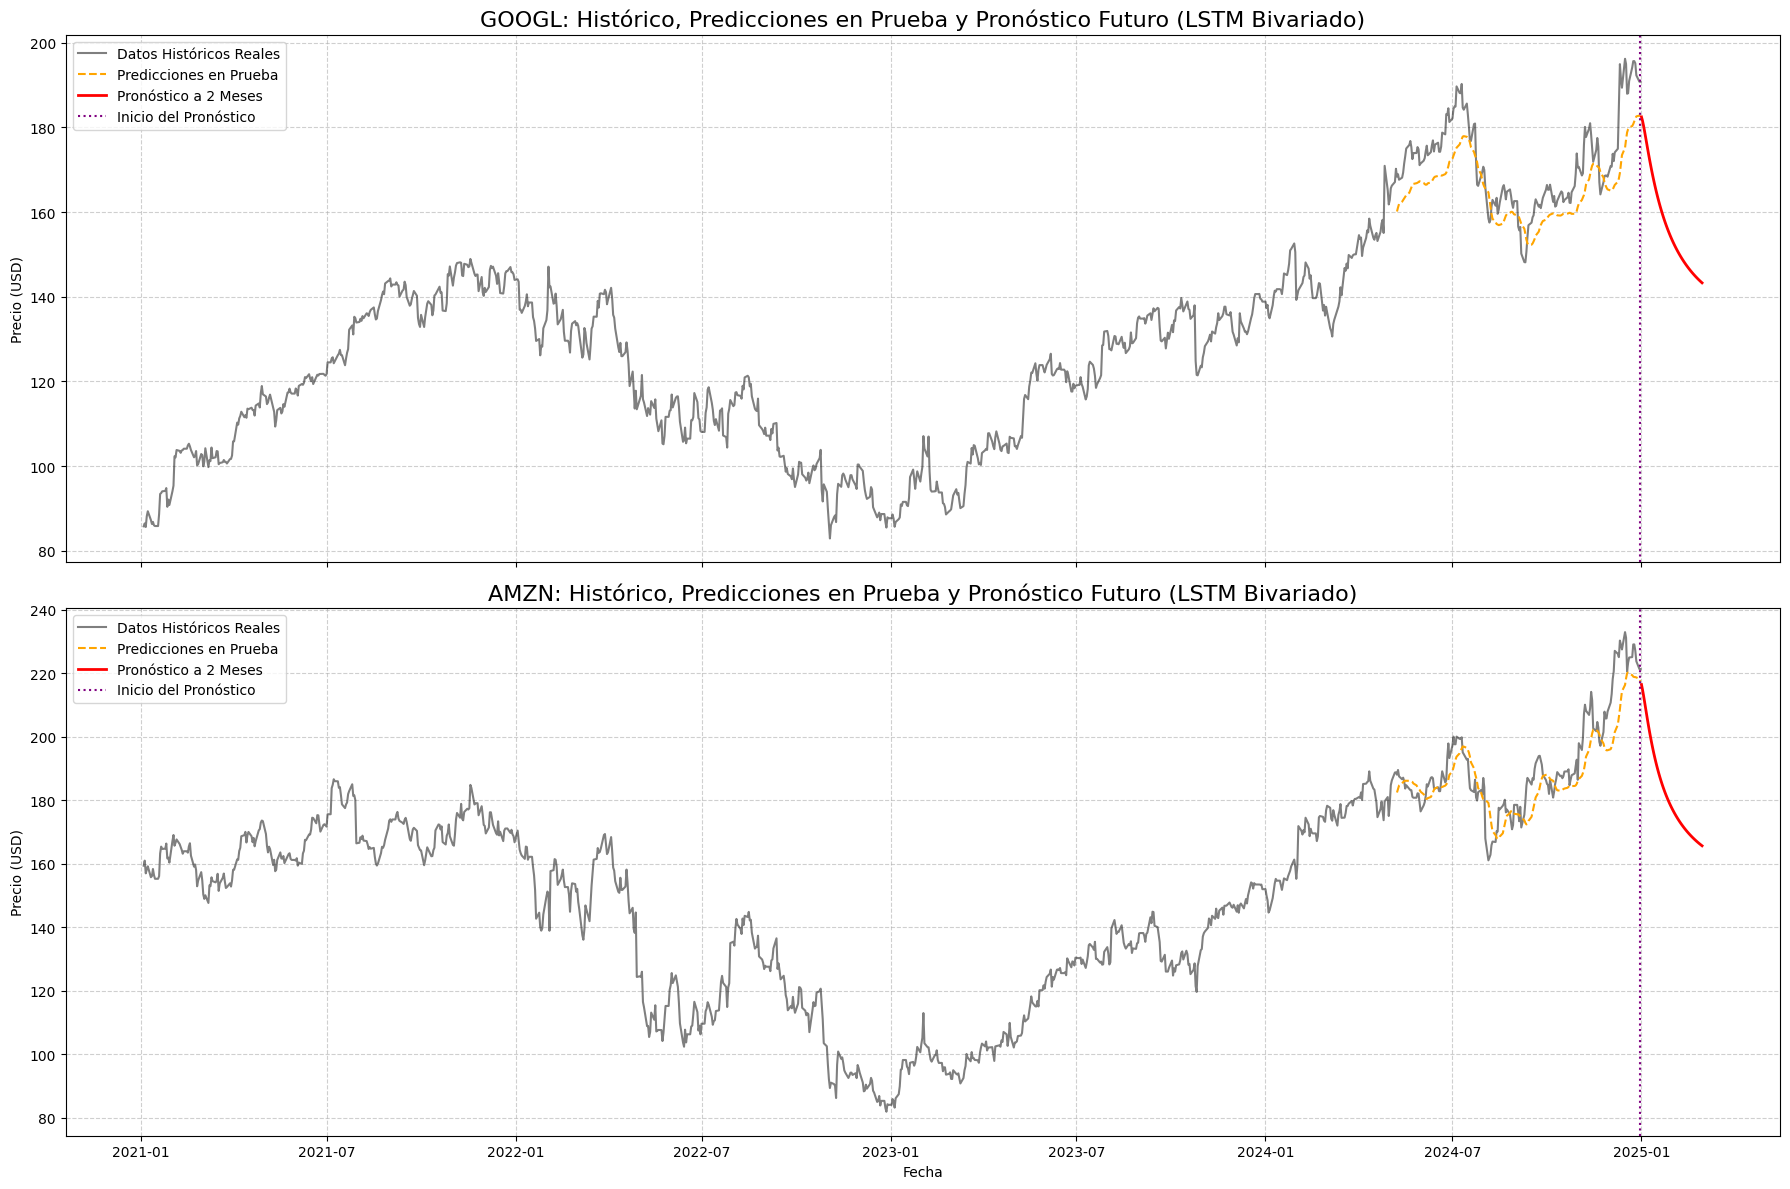

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Generando Pronósticos a Futuro con el Modelo LSTM Bivariado ---")

# 1. Definir el período de pronóstico
n_future_days = 60 # Aproximadamente 2 meses de días de negociación

# 2. Preparar la última secuencia de datos reales como punto de partida
last_sequence = scaled_biv[-n_steps:]
current_batch = last_sequence.reshape(1, n_steps, 2) # Formato para la entrada del LSTM

# 3. Bucle para generar pronósticos iterativos
future_predictions_scaled = []
for i in range(n_future_days):
    # Predecir el siguiente paso
    next_pred_scaled = model_bivariate.predict(current_batch)[0]

    # Almacenar la predicción
    future_predictions_scaled.append(next_pred_scaled)

    # Actualizar el batch: se elimina el dato más antiguo y se añade la nueva predicción al final
    current_batch = np.append(current_batch[:, 1:, :], [[next_pred_scaled]], axis=1)

# 4. Revertir la escala de las predicciones futuras
future_predictions_price = scaler_biv.inverse_transform(future_predictions_scaled)

# 5. Crear el índice de fechas para el pronóstico
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_future_days)

# 6. Crear la tabla de pronósticos
forecast_df_biv = pd.DataFrame({
    'GOOGL_Pronostico_Biv': future_predictions_price[:, 0],
    'AMZN_Pronostico_Biv': future_predictions_price[:, 1]
}, index=forecast_dates)
forecast_df_biv.index.name = 'Fecha_Pronostico'

print("\n--- Muestra de la Tabla de Pronósticos a 2 Meses (Modelo Bivariado) ---")
print(forecast_df_biv.head())
print("\nÚltimas fechas del pronóstico:")
print(forecast_df_biv.tail())


# 7. Gráfico final completo (Histórico + Predicciones en Prueba + Pronóstico a Futuro)
# Necesitamos los objetos de la celda de evaluación anterior:
# real_prices_biv, predictions_biv_price, y el índice de prueba.
test_dates = df.index[-len(real_prices_biv):]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# --- Gráfico para Google ---
ax1.plot(df.index, df['GOOGL_Close'], label='Datos Históricos Reales', color='black', alpha=0.5)
ax1.plot(test_dates, predictions_biv_price[:, 0], label='Predicciones en Prueba', color='orange', linestyle='--')
ax1.plot(forecast_dates, future_predictions_price[:, 0], label='Pronóstico a 2 Meses', color='red', linewidth=2)
ax1.axvline(df.index[-1], color='purple', linestyle=':', label='Inicio del Pronóstico')
ax1.set_title('GOOGL: Histórico, Predicciones en Prueba y Pronóstico Futuro (LSTM Bivariado)', fontsize=16)
ax1.set_ylabel('Precio (USD)')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Gráfico para Amazon ---
ax2.plot(df.index, df['AMZN_Close'], label='Datos Históricos Reales', color='black', alpha=0.5)
ax2.plot(test_dates, predictions_biv_price[:, 1], label='Predicciones en Prueba', color='orange', linestyle='--')
ax2.plot(forecast_dates, future_predictions_price[:, 1], label='Pronóstico a 2 Meses', color='red', linewidth=2)
ax2.axvline(df.index[-1], color='purple', linestyle=':', label='Inicio del Pronóstico')
ax2.set_title('AMZN: Histórico, Predicciones en Prueba y Pronóstico Futuro (LSTM Bivariado)', fontsize=16)
ax2.set_ylabel('Precio (USD)')
ax2.set_xlabel('Fecha')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# (Se asume que la sección 1, 2 y 3 - Definición, Compilación y Entrenamiento - ya se ha ejecutado)
# ...

# 4. Realizar Predicciones y Evaluar
print("\nRealizando predicciones multivariantes en el conjunto de prueba...")
predictions_multi_scaled = model_multivariate.predict(X_test_multi)

# --- CORRECCIÓN DEFINITIVA EN ESTA SECCIÓN ---

# El scaler_multi espera una entrada con n_features (11) columnas.
# Nuestras predicciones y nuestro 'y_test' solo tienen 2 columnas.
# Por lo tanto, debemos reconstruir el array completo para ambos.

# Reconstruir el array para las PREDICCIONES
dummy_predictions = np.zeros((predictions_multi_scaled.shape[0], n_features))
dummy_predictions[:, :n_outputs] = predictions_multi_scaled
predictions_full = scaler_multi.inverse_transform(dummy_predictions)
predictions_multi_price = predictions_full[:, :n_outputs] # Seleccionar solo GOOGL y AMZN

# Reconstruir el array para los VALORES REALES DE PRUEBA
dummy_y_test = np.zeros((y_test_multi.shape[0], n_features))
dummy_y_test[:, :n_outputs] = y_test_multi
real_prices_full = scaler_multi.inverse_transform(dummy_y_test)
real_prices_multi = real_prices_full[:, :n_outputs] # Seleccionar solo GOOGL y AMZN

# --- FIN DE LA CORRECCIÓN ---


# Crear DataFrames para facilitar el manejo de métricas
output_columns = df_multi_features.columns[:n_outputs].tolist()
df_real_multi = pd.DataFrame(real_prices_multi, columns=output_columns, index=X_test.index[-len(real_prices_multi):])
df_pred_multi = pd.DataFrame(predictions_multi_price, columns=output_columns, index=X_test.index[-len(predictions_multi_price):])

# Calcular y mostrar métricas para las variables predichas
results_multi_comparison = {}
print("\n--- Evaluación Final del Modelo LSTM Multivariado (por variable objetivo) ---")
for col in output_columns:
    mse = mean_squared_error(df_real_multi[col], df_pred_multi[col])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(df_real_multi[col], df_pred_multi[col])
    r2 = r2_score(df_real_multi[col], df_pred_multi[col])
    mape = mean_absolute_percentage_error(df_real_multi[col], df_pred_multi[col])

    # Añadimos los resultados al diccionario general 'results' para la tabla final
    results[f'LSTM Multivariado ({col.split("_")[0]})'] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

results_df_multi_comp = pd.DataFrame(results).T.sort_values(by="MSE")
print(results_df_multi_comp)

# Guardar predicciones de GOOGL y AMZN para el gráfico final comparativo
lstm_multi_predictions_googl = df_pred_multi['GOOGL_Close']
lstm_multi_predictions_amzn = df_pred_multi['AMZN_Close']


Realizando predicciones multivariantes en el conjunto de prueba...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

--- Evaluación Final del Modelo LSTM Multivariado (por variable objetivo) ---
                                  MSE       RMSE        MAE        R2  \
Regresion Lineal            11.734874   3.425620   2.464030  0.911391   
Gradient Boosting           35.911321   5.992606   5.029520  0.728836   
LSTM Bivariado              39.511885   6.285848   5.263183  0.645018   
Random Forest               43.047990   6.561097   5.783452  0.674947   
LSTM Bivariado (GOOGL)      66.069298   8.128302   6.973153  0.406421   
LSTM Bivariado (AMZN)       67.460454   8.213431   6.302695  0.737410   
LSTM Multivariado (AMZN)    78.901497   8.882651   7.038548  0.716436   
LSTM Multivariado (GOOGL)   79.783340   8.932152   7.055925  0.362218   
ARIMA                      754.054363  27.460050  24.890941 -4.697961   

                                MAPE  
Regresion Lineal            1.446053  
Gradie

In [109]:
print("\n--- Generando Pronósticos a Futuro con el Modelo LSTM Multivariado ---")

# 1. Definir el período de pronóstico
n_future_days = 60 # Aprox. 2 meses

# 2. Preparar la última secuencia de datos reales como punto de partida
# scaled_multi contiene todas las características normalizadas
last_sequence = scaled_multi[-n_steps:]
current_batch = last_sequence.reshape(1, n_steps, n_features)

# 3. Bucle para generar pronósticos iterativos
future_predictions_scaled = []
for i in range(n_future_days):
    # Predecir el siguiente paso (esto devuelve solo 2 valores: GOOGL y AMZN)
    next_pred_target_only = model_multivariate.predict(current_batch, verbose=0)[0]

    # --- CORRECCIÓN CLAVE AQUÍ ---
    # Necesitamos construir la fila completa de 11 características para el siguiente paso.

    # Tomamos la última fila conocida de características exógenas
    last_known_exog_features = current_batch[0, -1, n_outputs:]

    # Creamos la nueva fila completa: [pred_googl, pred_amzn, exog_1, exog_2, ...]
    next_full_step = np.concatenate([next_pred_target_only, last_known_exog_features])

    # Almacenamos solo las predicciones de las variables objetivo
    future_predictions_scaled.append(next_pred_target_only)

    # Actualizar el batch con la nueva fila completa
    current_batch = np.append(current_batch[:, 1:, :], [[next_full_step]], axis=1)
    # --- FIN DE LA CORRECCIÓN ---


# 4. Revertir la escala de las predicciones futuras (solo las de GOOGL y AMZN)
predictions_to_inverse = np.array(future_predictions_scaled)
dummy_future = np.zeros((len(predictions_to_inverse), n_features))
dummy_future[:, :n_outputs] = predictions_to_inverse
future_predictions_price = scaler_multi.inverse_transform(dummy_future)[:, :n_outputs]


# 5. Crear el índice de fechas y la tabla de pronósticos
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_future_days)
# Ahora la tabla contendrá solo las dos columnas pronosticadas
forecast_df_multi = pd.DataFrame(
    future_predictions_price,
    index=forecast_dates,
    columns=df_multi_features.columns[:n_outputs]
)
forecast_df_multi.index.name = 'Fecha_Pronostico'

print("\n--- Muestra de la Tabla de Pronósticos Multivariantes a 2 Meses ---")
print(forecast_df_multi.head())
print("\nÚltimas fechas del pronóstico:")
print(forecast_df_multi.tail())


--- Generando Pronósticos a Futuro con el Modelo LSTM Multivariado ---

--- Muestra de la Tabla de Pronósticos Multivariantes a 2 Meses ---
                  AMZN_Close  GOOGL_Close
Fecha_Pronostico                         
2025-01-01        214.841960   181.441478
2025-01-02        213.489130   180.352798
2025-01-03        211.989371   179.142478
2025-01-04        210.506157   177.945700
2025-01-05        209.126667   176.831603

Últimas fechas del pronóstico:
                  AMZN_Close  GOOGL_Close
Fecha_Pronostico                         
2025-02-25        200.485749   169.921161
2025-02-26        200.485497   169.921006
2025-02-27        200.485307   169.920857
2025-02-28        200.485154   169.920743
2025-03-01        200.485019   169.920662



--- Visualizando los Resultados y Pronósticos del Modelo Multivariado ---


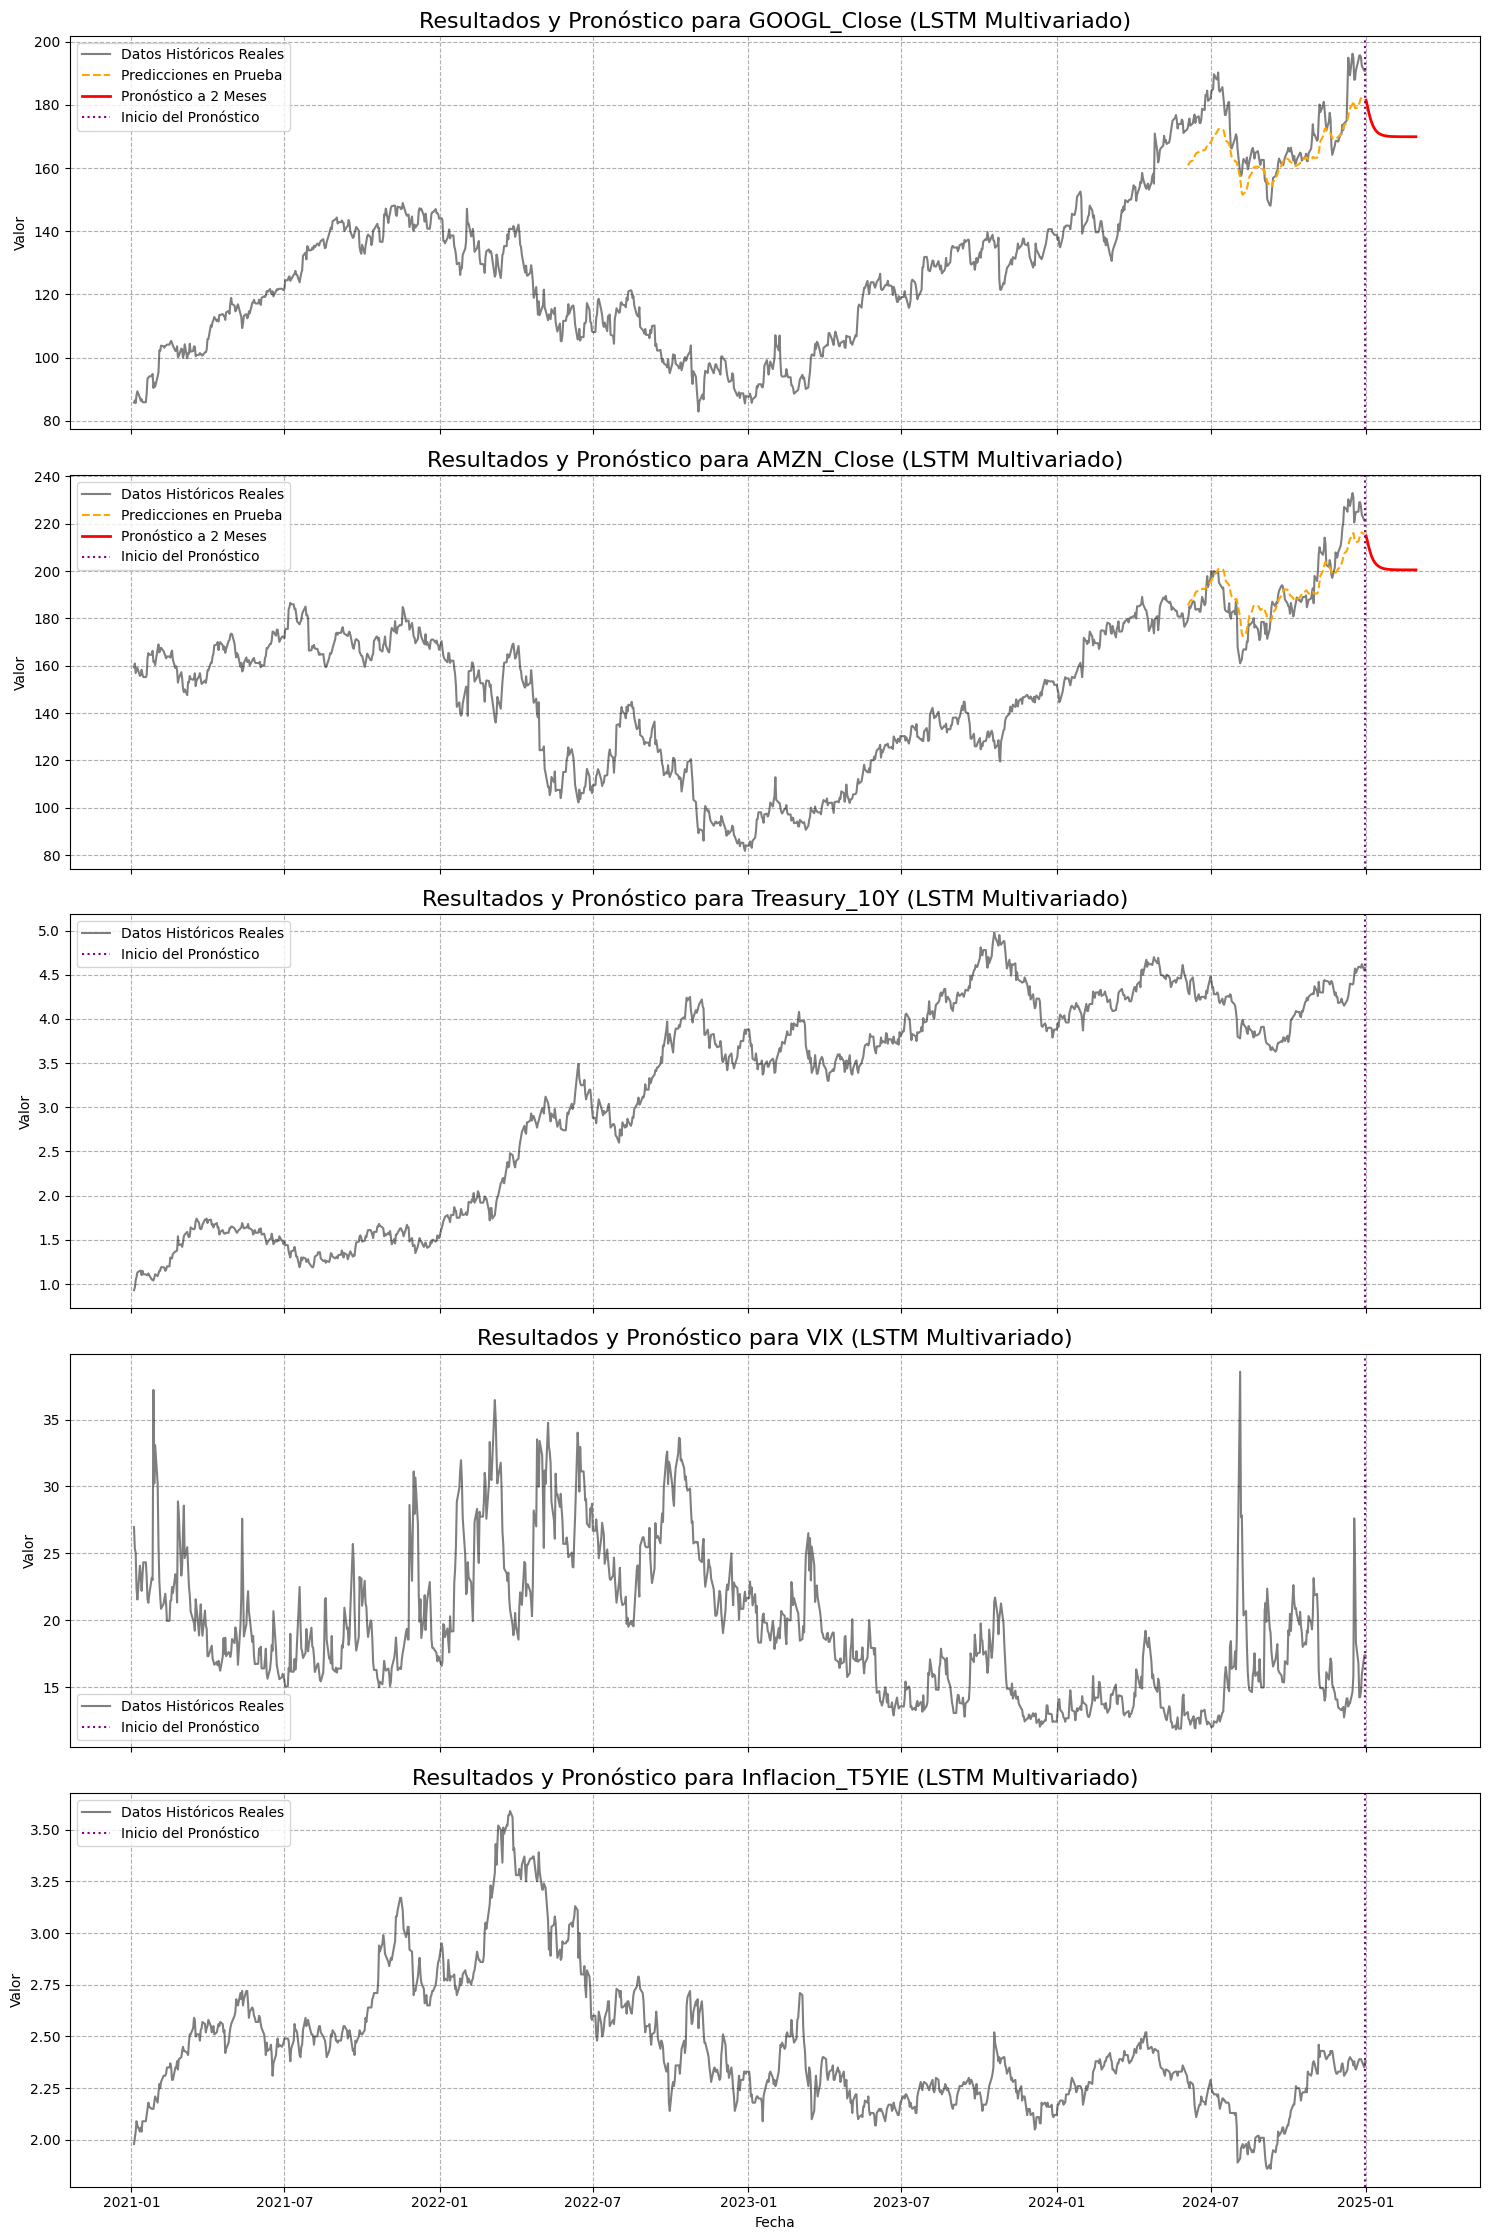

In [110]:
print("\n--- Visualizando los Resultados y Pronósticos del Modelo Multivariado ---")

# Seleccionar las columnas clave para visualizar
# Nos aseguramos de que los nombres coincidan con los del DataFrame original 'df'
columns_to_plot = ['GOOGL_Close', 'AMZN_Close', 'Treasury_10Y', 'VIX', 'Inflacion_T5YIE']
n_plots = len(columns_to_plot)

fig, axes = plt.subplots(n_plots, 1, figsize=(15, n_plots * 4.5), sharex=True)

for i, col in enumerate(columns_to_plot):
    ax = axes[i]

    # 1. Graficar los datos históricos completos
    ax.plot(df.index, df[col], label='Datos Históricos Reales', color='black', alpha=0.5)

    # 2. Graficar las predicciones sobre el conjunto de prueba
    # df_pred_multi contiene las predicciones del modelo en el test set
    if col in df_pred_multi.columns:
        ax.plot(df_pred_multi.index, df_pred_multi[col], label='Predicciones en Prueba', color='orange', linestyle='--')

    # 3. Graficar el pronóstico a futuro
    # --- CORRECCIÓN AQUÍ: Usar 'forecast_df_multi' ---
    # forecast_df_multi contiene los pronósticos futuros
    if col in forecast_df_multi.columns:
        ax.plot(forecast_df_multi.index, forecast_df_multi[col], label='Pronóstico a 2 Meses', color='red', linewidth=2)

    # 4. Añadir una línea vertical para marcar el inicio del pronóstico
    ax.axvline(df.index[-1], color='purple', linestyle=':', label='Inicio del Pronóstico')

    # Títulos y etiquetas
    ax.set_title(f'Resultados y Pronóstico para {col} (LSTM Multivariado)', fontsize=16)
    ax.set_ylabel('Valor')
    ax.legend()
    ax.grid(True, linestyle='--')

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()

## CREANDO PRONOSTICOS PARA TODAS LAS VARIABLES EN LTSM

In [ ]:
print("\n--- Entrenando Modelo 6 (Revisado): LSTM Multivariante Completo ---")

# La preparación de datos (X_multi, y_multi) de la celda 9 es la misma.
# Sin embargo, el objetivo 'y' ahora debe tener todas las características.
# n_features ya está definido como el número total de columnas.

def create_full_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])
        y.append(data[i + n_steps, :]) # El objetivo es la fila completa del siguiente paso
    return np.array(X), np.array(y)

X_multi_full, y_multi_full = create_full_sequences(scaled_multi, n_steps)

# Dividir de nuevo para asegurar que 'y' tenga la forma correcta
train_size_full = int(len(X_multi_full) * 0.8)
X_train_full, X_test_full = X_multi_full[:train_size_full], X_multi_full[train_size_full:]
y_train_full, y_test_full = y_multi_full[:train_size_full], y_multi_full[train_size_full:]


# 1. Definir la Arquitectura del Modelo
model_full_output = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(n_steps, n_features)),
    Dropout(0.3),
    LSTM(units=50, return_sequences=False),
    Dropout(0.3),
    Dense(units=n_features) # <-- CAMBIO CLAVE: La salida predice TODAS las características
])

# 2. Compilar y Entrenar
model_full_output.compile(optimizer='adam', loss='mean_squared_error')
print("\nArquitectura del Modelo LSTM Multivariante Completo:")
model_full_output.summary()

print("\nIniciando entrenamiento...")
history_full = model_full_output.fit(
    X_train_full, y_train_full,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_full, y_test_full),
    verbose=1,
    shuffle=False
)

# 3. Visualizar Curva de Aprendizaje
plt.figure(figsize=(12, 6))
plt.plot(history_full.history['loss'], label='Pérdida de Entrenamiento (MSE Total)')
plt.plot(history_full.history['val_loss'], label='Pérdida de Validación (MSE Total)')
plt.title('Curva de Aprendizaje del Modelo LSTM Multivariante Completo')
plt.xlabel('Época')
plt.ylabel('Error Cuadrático Medio (Loss)')
plt.legend()
plt.grid(True)
plt.show()


--- Entrenando Modelo 6 (Revisado): LSTM Multivariante Completo ---

Arquitectura del Modelo LSTM Multivariante Completo:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 60, 100)        │        44,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,561 (295.16 KB)

 Trainable params: 75,561 (295.16 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.0758 - val_loss: 0.0670
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0662 - val_loss: 0.0666
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0437 - val_loss: 0.0420
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0342 - val_loss: 0.0219
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0281 - val_loss: 0.0338
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0268 - val_loss: 0.0240
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0238 - val_loss: 0.0227
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.0258 - val_loss: 0.0324
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0354 - val_loss: 0.0207
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0290 - val_loss: 0.0405
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0258 - val_loss: 0.0192
Epoch 12/50
25/25 ━━━━━━━━━

In [79]:
print("\n--- Evaluación del Modelo Multivariante Completo ---")
# Realizar predicciones
predictions_full_scaled = model_full_output.predict(X_test_full)

# Revertir la normalización
predictions_full_price = scaler_multi.inverse_transform(predictions_full_scaled)
real_prices_full = scaler_multi.inverse_transform(y_test_full)

# Crear DataFrames para facilitar el manejo
df_real_full = pd.DataFrame(real_prices_full, columns=df_multi_features.columns, index=X_test.index[-len(real_prices_full):])
df_pred_full = pd.DataFrame(predictions_full_price, columns=df_multi_features.columns, index=X_test.index[-len(predictions_full_price):])

# Calcular y mostrar métricas para cada variable
results_full_model = {}
for col in df_multi_features.columns:
    mse = mean_squared_error(df_real_full[col], df_pred_full[col])
    r2 = r2_score(df_real_full[col], df_pred_full[col])
    results_full_model[col] = {'MSE': mse, 'R2': r2}

results_df_full = pd.DataFrame(results_full_model).T
print("\n--- Tabla de Métricas de Rendimiento por Variable (Test Set) ---")
print(results_df_full)


--- Evaluación del Modelo Multivariante Completo ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step

--- Tabla de Métricas de Rendimiento por Variable (Test Set) ---
                                     MSE          R2
AMZN_Close                     66.156802   -7.383983
GOOGL_Close                    49.711494   -2.337405
SP500                       16539.378275   -2.988747
NASDAQ                     650252.468565   -8.736004
VIX                             5.816294   -0.846510
Treasury_10Y                    0.002101    0.453356
Inflacion_T5YIE                 0.003993   -3.334988
GOOGL_Close_Return_1d           0.000810   -1.820557
GOOGL_Close_Volatility_20       0.000012  -11.607309
AMZN_Close_Return_1d            0.000651   -2.867505
AMZN_Close_Volatility_20        0.000033 -305.271136


In [80]:
print("\n--- Generando Pronósticos a Futuro para TODAS las Variables ---")

# 1. Definir período de pronóstico
n_future_days = 60

# 2. Preparar la última secuencia de datos reales
last_sequence = scaled_multi[-n_steps:]
current_batch = last_sequence.reshape(1, n_steps, n_features)

# 3. Bucle de pronóstico iterativo
future_predictions_scaled = []
for i in range(n_future_days):
    # Predecir el siguiente estado completo de todas las variables
    next_pred_scaled = model_full_output.predict(current_batch, verbose=0)[0]
    future_predictions_scaled.append(next_pred_scaled)
    # Actualizar el batch con la nueva predicción completa
    current_batch = np.append(current_batch[:, 1:, :], [[next_pred_scaled]], axis=1)

# 4. Revertir la escala y crear la tabla de pronósticos
future_predictions_all_vars = scaler_multi.inverse_transform(future_predictions_scaled)
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_future_days)
forecast_df_all_vars = pd.DataFrame(future_predictions_all_vars, index=forecast_dates, columns=df_multi_features.columns)
forecast_df_all_vars.index.name = 'Fecha_Pronostico'

print("\n--- Muestra de la Tabla de Pronósticos Multivariantes Completos ---")
print(forecast_df_all_vars.head())


--- Generando Pronósticos a Futuro para TODAS las Variables ---

--- Muestra de la Tabla de Pronósticos Multivariantes Completos ---
                  AMZN_Close  GOOGL_Close        SP500        NASDAQ  \
Fecha_Pronostico                                                       
2025-06-28        205.686118   178.438229  5940.350669  18972.395104   
2025-06-29        205.725691   178.580478  5939.996590  18970.794892   
2025-06-30        205.615567   178.565573  5933.878605  18946.204668   
2025-07-01        205.387915   178.433005  5923.552861  18905.089533   
2025-07-02        205.079693   178.222106  5910.323671  18851.773476   

                        VIX  Treasury_10Y  Inflacion_T5YIE  \
Fecha_Pronostico                                             
2025-06-28        17.021283      4.302950         2.256383   
2025-06-29        16.968793      4.299492         2.254316   
2025-06-30        16.900423      4.294431         2.251790   
2025-07-01        16.835446      4.288050         2


--- Visualizando los Resultados y Pronósticos Completos ---


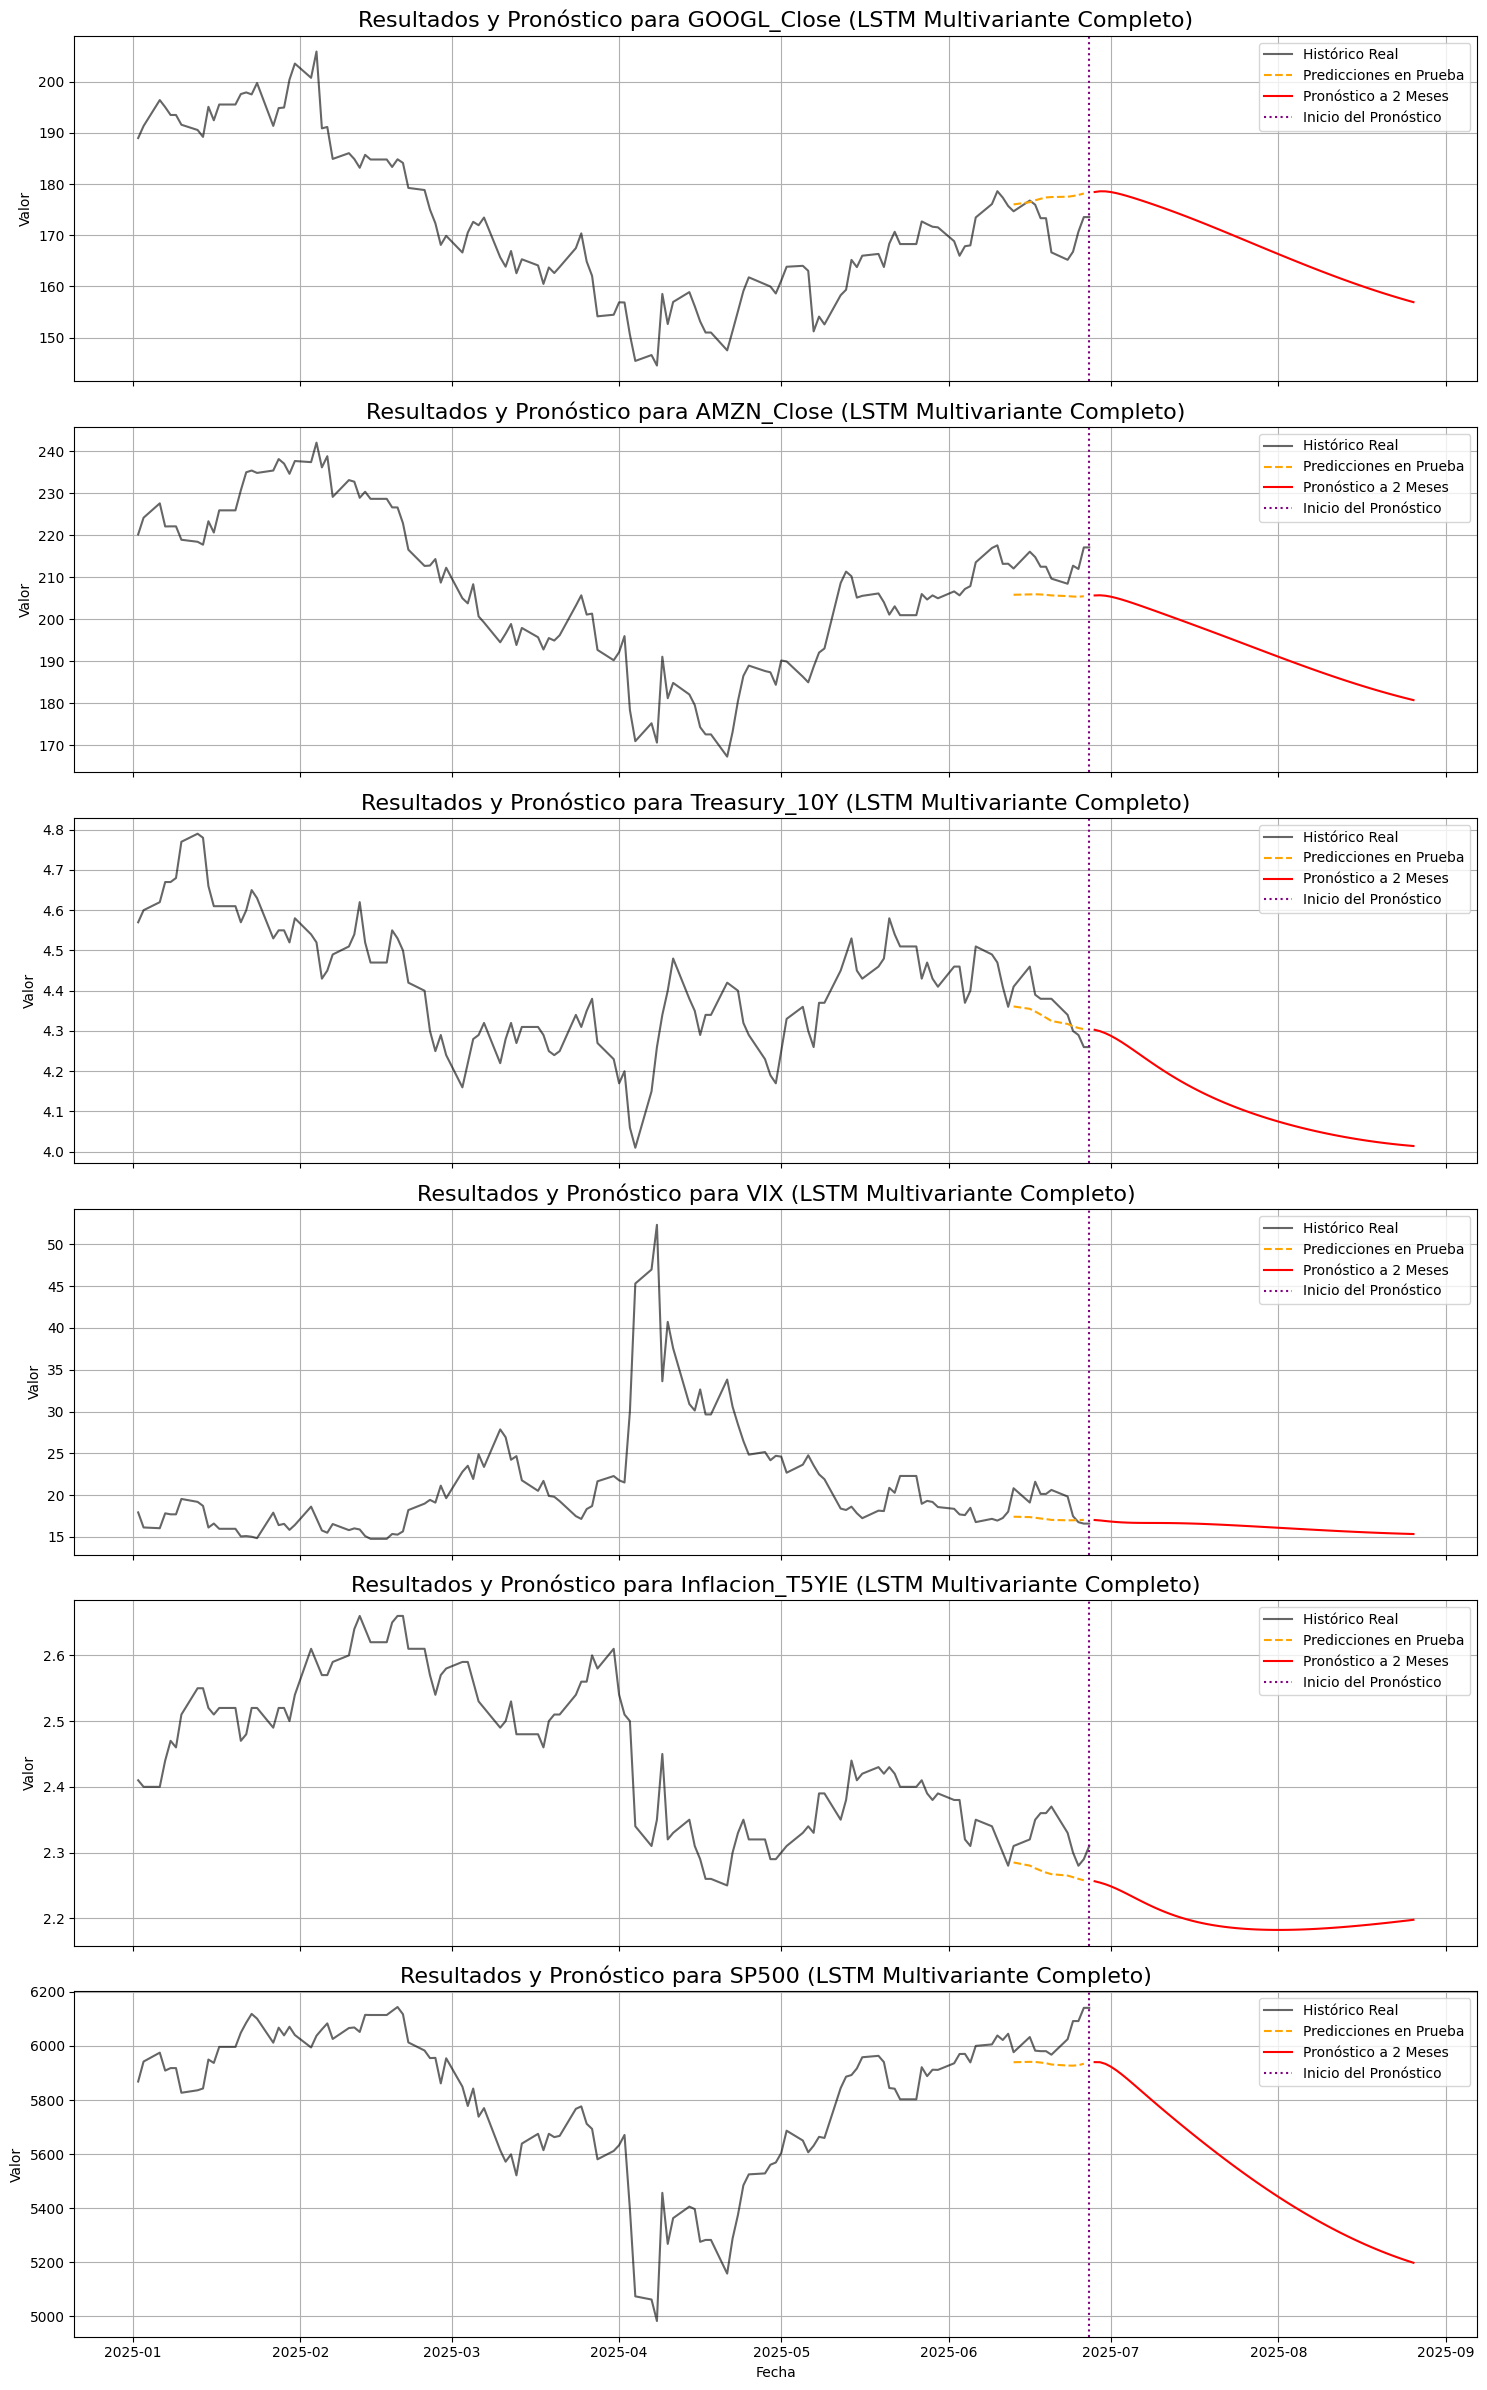

In [81]:
print("\n--- Visualizando los Resultados y Pronósticos Completos ---")

columns_to_plot = ['GOOGL_Close', 'AMZN_Close', 'Treasury_10Y', 'VIX', 'Inflacion_T5YIE', 'SP500']
n_plots = len(columns_to_plot)
fig, axes = plt.subplots(n_plots, 1, figsize=(15, n_plots * 4), sharex=True)

for i, col in enumerate(columns_to_plot):
    ax = axes[i]

    # Datos históricos
    ax.plot(df[col], label='Histórico Real', color='black', alpha=0.6)

    # Predicciones sobre el conjunto de prueba
    ax.plot(df_pred_full[col], label='Predicciones en Prueba', color='orange', linestyle='--')

    # Pronóstico a futuro
    ax.plot(forecast_df_all_vars[col], label='Pronóstico a 2 Meses', color='red')

    ax.axvline(df.index[-1], color='purple', linestyle=':', label='Inicio del Pronóstico')
    ax.set_title(f'Resultados y Pronóstico para {col} (LSTM Multivariante Completo)', fontsize=16)
    ax.set_ylabel('Valor')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()